In [1]:
%matplotlib notebook

This notebook contains all the plots created for Figure 1 Sup3.

This figure explains the detection Mode #3, explained here: https://pivr.readthedocs.io/en/latest/code_explanation.html#reconstruct-background-by-stitching-mode-3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas 
import os
import scipy
from scipy import ndimage
from skimage.measure import regionprops, label
import matplotlib.patches as patches
import operator
import matplotlib.gridspec as gridspec
from skimage import morphology
#plt.style.use('ggplot')
import json
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FixedLocator
from matplotlib.patches import FancyArrowPatch
import operator
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import os
from pathlib import Path

In [3]:
home_path = os.getcwd()
# set to true to save the plots
save_plots = False

In [4]:
datapath = Path('data/detection_data')
os.chdir(home_path)
os.chdir(datapath)
all_images = np.load('all_images.npy')
targetpath = Path('plots/Fig1S3')

In [5]:
# larva data
larva={'filled_area_min_mm' : 5,
       'filled_area_max_mm' : 55,
       'eccentricity_min' : 0.7,
       'eccentricity_max' : 1,
       'major_over_minor_axis_min' : 1.25,
       'major_over_minor_axis_max' : 7,
       'max_skeleton_length_mm' : 5,
       'max_speed_animal_mm_per_s' : 2}
with open(('experiment_settings.json'), 'r') as file:
    experiment_settings = json.load(file)
print(experiment_settings)

{'Framerate': 2, 'Pixel per mm': 5.12, 'Recording time': 300}


In [6]:
filled_area_min = larva['filled_area_min_mm'] * experiment_settings['Pixel per mm']
filled_area_max = larva['filled_area_max_mm'] * experiment_settings['Pixel per mm']
eccentricity_min = larva['eccentricity_min']
eccentricity_max = larva['eccentricity_max']
major_over_minor_axis_min = larva['major_over_minor_axis_min']
major_over_minor_axis_max = larva['major_over_minor_axis_max']
max_speed_animal_mm_per_s = larva['max_speed_animal_mm_per_s']
max_skeleton_length_mm = larva['max_skeleton_length_mm']
pixel_per_mm = experiment_settings['Pixel per mm']
signal = 'dark'

In [7]:
# Some variables
minimal_cross_section_animal = (major_over_minor_axis_min/filled_area_min)*experiment_settings['Pixel per mm']
if minimal_cross_section_animal < 2:
    minimal_cross_section_animal = 2 # because minimum detectable thickness is one pixel
sigma_for_image_filtering = minimal_cross_section_animal/2
if sigma_for_image_filtering > 2.5:
    sigma_for_image_filtering = 2.5 # empirical
print(repr(sigma_for_image_filtering) + ' sigma for filtering')
boxsize = larva['max_speed_animal_mm_per_s']/int(experiment_settings['Framerate']) * experiment_settings['Pixel per mm']
stringency_size = 0.01
stringency_centroid = 0.01
sigma_threshold_before_roi = 2

1.0 sigma for filtering


In [8]:
class CallImageROI():
    '''
    In order to keep the code as tidy as possible I'll try to use this class to have a 
    shorter way to call a slice of the image using the roi object.
    '''

    def __init__(self, image, roi, boxsize = None, sliced_input_image = None):

        self.image = image
        self.row_min = roi.row_min
        self.row_max = roi.row_max
        self.col_min = roi.col_min
        self.col_max = roi.col_max
        if boxsize != None:
            self.boxsize = boxsize
        else:
            self.boxsize = None
        if sliced_input_image is not None:
            self.sliced_input_image = True
            self.subtract_row = sliced_input_image[0]
            self.subtract_col = sliced_input_image[1]
        else:
            self.sliced_input_image = None

        self.call_image()

    def call_image(self):
        if self.boxsize is not None:
            self.small_image = self.image[int(self.row_min-self.boxsize):int(self.row_max+self.boxsize),
                               int(self.col_min-self.boxsize):int(self.col_max+self.boxsize)]
        elif self.sliced_input_image is not None:
            self.small_image = self.image[int(self.row_min - self.subtract_row):int(self.row_max - self.subtract_row),
                                            int(self.col_min - self.subtract_col):int(self.col_max - self.subtract_col)]
        else:
            self.small_image = self.image[int(self.row_min):int(self.row_max),int(self.col_min):int(self.col_max)]



In [9]:
class FindROI:
    '''
    This class is used to define the region of interest from a given regionpropertie class.
    It also makes sure that the box is never outside of the frame.
    '''
    def __init__(self, regionproperties, boxsize, size_factor,image):

        self.regionproperties = regionproperties
        self.boxsize = boxsize
        self.size_factor = size_factor
        self.image = image

        self.row_min = 0
        self.row_max = 0
        self.col_min = 0
        self.col_max = 0

        self.centroid_row = 0
        self.centroid_col = 0

        self.assign()

    def assign(self):
        self.row_min = self.regionproperties.centroid[0] - self.boxsize * self.size_factor
        self.row_max = self.regionproperties.centroid[0] + self.boxsize * self.size_factor
        self.col_min = self.regionproperties.centroid[1] - self.boxsize * self.size_factor
        self.col_max = self.regionproperties.centroid[1] + self.boxsize * self.size_factor

        if self.row_min < 0:
            self.row_min = 0
        if self.col_min < 0:
            self.col_min = 0
        if self.row_max > self.image.shape[0]:
            self.row_max = self.image.shape[0] - 1
        if self.col_max > self.image.shape[1]:
            self.col_max = self.image.shape[1] - 1

        self.centroid_row = self.regionproperties.centroid[0]
        self.centroid_col = self.regionproperties.centroid[1]

In [10]:
class CallBoundingBox():
    '''
    uses the bounding box numpy array to slice an image

    '''

    def __init__(self, image, bounding_box):
        self.image = image
        self.row_min = bounding_box[0]
        self.row_max = bounding_box[1]
        self.col_min = bounding_box[2]
        self.col_max = bounding_box[3]

        self.slice_image()

    def slice_image(self):
        self.sliced_image = self.image[int(self.row_min):int(self.row_max),
                                    int(self.col_min):int(self.col_max)]

In [11]:
class DescribeLargestObject():
    '''
    This class analyzes a binary image and defines the largest object and saves it's bounding box,
    its major and minor axis and its centroid coordinates
    '''

    def __init__(self, regioproperties, roi, boxsize = None, animal_like=False, filled_area_min=None,
                 filled_area_max=None, eccentricity_min=None, eccentricity_max=None,
                 major_over_minor_axis_min=None, major_over_minor_axis_max=None
                 ):
        '''

        :param regioproperties: An regionproperties object defined from the skimage library
        :param roi: The part of the image that has been identified in the previous loop where the animal should now be
        found
        :param boxsize: ?
        '''

        self.filled_area = 0
        self.eccentricity = 0
        self.row_min = 0
        self.row_max = 0
        self.col_min = 0
        self.col_max = 0
        self.centroid_row = 0
        self.centroid_col = 0
        self.major_axis = 0
        self.minor_axis = 0
        if boxsize != None:
            self.boxsize = boxsize
        else:
            self.boxsize = 0

        self.regionproperties = regioproperties
        try: # if roi is an roi object (pre_experiment)
            self.row_min_internal = roi.row_min
            self.col_min_internal = roi.col_min
        except AttributeError: # else if roi is a list
            self.row_min_internal = roi[0]
            self.col_min_internal = roi[1]

        # boolean switch that will turn as soon as something like one of the if clauses that defines the animal has
        # been triggered at least once
        self.animal_like_object_detected = False

        if animal_like:
            self.filled_area_min = filled_area_min
            self.filled_area_max = filled_area_max
            self.eccentricity_min = eccentricity_min
            self.eccentricity_max = eccentricity_max
            self.major_over_minor_axis_min = major_over_minor_axis_min
            self.major_over_minor_axis_max = major_over_minor_axis_max
            self.animal_like_object()
        else:
            self.largest_object()

    def largest_object(self):

        datatype =  [('filled area', np.uint16), ('row min', np.uint16), ('col min', np.uint16),
                     ('row max', np.uint16), ('col max', np.uint16), ('centroid row', np.uint16),
                     ('centroid col', np.uint16), ('minor axis', np.float32), ('major axis', np.float32),
                     ('eccentricity',np.float32)]
        areas = np.zeros((len(self.regionproperties)), dtype=datatype)
        for j_areas in range(len(self.regionproperties)):
            areas['filled area'][j_areas] = self.regionproperties[j_areas].filled_area
            # To get the "real" coordinate (relative to the original picture) and not just the coordinates of the
            # small picture the minimal row/col needs to be added to the found box
            areas['row min'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[0]
            areas['col min'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[1]
            areas['row max'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[2]
            areas['col max'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[3]
            areas['centroid row'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].centroid[0]
            areas['centroid col'][j_areas] = self.col_min_internal - self.boxsize+ self.regionproperties[j_areas].centroid[1]
            areas['minor axis'][j_areas] = self.regionproperties[j_areas].minor_axis_length
            areas['major axis'][j_areas] = self.regionproperties[j_areas].major_axis_length
            areas['eccentricity'][j_areas] = self.regionproperties[j_areas].eccentricity
        areas_sorted = np.sort(areas, order='filled area')
        self.filled_area = areas_sorted['filled area'][-1]
        self.row_min = areas_sorted['row min'][-1]
        self.row_max = areas_sorted['row max'][-1]
        self.col_min = areas_sorted['col min'][-1]
        self.col_max = areas_sorted['col max'][-1]
        self.centroid_row = areas_sorted['centroid row'][-1]
        self.centroid_col = areas_sorted['centroid col'][-1]
        self.minor_axis = areas_sorted['minor axis'][-1]
        self.major_axis = areas_sorted['major axis'][-1]
        self.eccentricity = areas_sorted['eccentricity'][-1]


    def animal_like_object(self):
        '''
        This function was written after the above was used for a while. It's essentially doing the same as the
        'describe the larges blob' with the difference that it checks for all the properties the algorithm was
        looking for in the first place (at the time of writting that essentially the covered area, the eccentricity
        and the major/minor axis ratio
        :return:
        '''
        datatype =  [('filled area', np.uint16), ('row min', np.uint16), ('col min', np.uint16),
                     ('row max', np.uint16), ('col max', np.uint16), ('centroid row', np.uint16),
                     ('centroid col', np.uint16), ('minor axis', np.float32), ('major axis', np.float32),
                     ('eccentricity', np.float32)]
        areas = np.zeros((len(self.regionproperties)), dtype=datatype)
        for j_areas in range(len(self.regionproperties)):

            print('self.regionproperties[j_areas].filled_area: ' + repr(self.regionproperties[j_areas].filled_area))
            print('self.regionproperties[j_areas].eccentricity: ' + repr(self.regionproperties[j_areas].eccentricity))
            try:
                print('ratio major/minor: ' +
                      repr(self.regionproperties[j_areas].major_axis_length /
                           self.regionproperties[j_areas].minor_axis_length))
            except ZeroDivisionError:
                print('cant divide by zero(minor axis length)')

            if self.filled_area_min < self.regionproperties[j_areas].filled_area < self.filled_area_max and \
                self.eccentricity_min < self.regionproperties[j_areas].eccentricity < self.eccentricity_max and \
                self.major_over_minor_axis_min < \
                    self.regionproperties[j_areas].major_axis_length / self.regionproperties[j_areas].minor_axis_length < \
                self.major_over_minor_axis_max:
                    print('found a blob that could be an animal')
                    areas['filled area'][j_areas] = self.regionproperties[j_areas].filled_area
                    # To get the "real" coordinate (relative to the original picture) and not just the coordinates of the
                    # small picture the minimal row/col needs to be added to the found box
                    areas['row min'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[0]
                    areas['col min'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[1]
                    areas['row max'][j_areas] = self.row_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[2]
                    areas['col max'][j_areas] = self.col_min_internal - self.boxsize + self.regionproperties[j_areas].bbox[3]
                    areas['centroid row'][j_areas] = self.row_min_internal - self.boxsize + \
                                                     self.regionproperties[j_areas].centroid[0]
                    areas['centroid col'][j_areas] = self.col_min_internal - self.boxsize + \
                                                     self.regionproperties[j_areas].centroid[1]
                    areas['minor axis'][j_areas] = self.regionproperties[j_areas].minor_axis_length
                    areas['major axis'][j_areas] = self.regionproperties[j_areas].major_axis_length
                    areas['eccentricity'][j_areas] = self.regionproperties[j_areas].eccentricity
                    self.animal_like_object_detected = True
        # After selecting for animal-like shape, sort to get the largest of the animal like shapes and define it as the
        # animal.
        areas_sorted = np.sort(areas, order='filled area')
        self.filled_area = areas_sorted['filled area'][-1]
        self.row_min = areas_sorted['row min'][-1]
        self.row_max = areas_sorted['row max'][-1]
        self.col_min = areas_sorted['col min'][-1]
        self.col_max = areas_sorted['col max'][-1]
        self.centroid_row = areas_sorted['centroid row'][-1]
        self.centroid_col = areas_sorted['centroid col'][-1]
        self.minor_axis = areas_sorted['minor axis'][-1]
        self.major_axis = areas_sorted['major axis'][-1]
        self.eccentricity = areas_sorted['eccentricity'][-1]



In [12]:
class MeanThresh():
    '''
    This class takes an image and calculates the mean intensities and standard deviation to calculate
    a threshold which can be use to segment the image.
    If no roi is given, the take whole image is taken into account. roi must be a roi class object

    '''
    def __init__(self, image, signal, sigma, roi = None, invert = False):

        self.thresh = 0

        self.image = image
        if roi != None:
            self.row_min = roi.row_min
            self.row_max = roi.row_max
            self.col_min = roi.col_min
            self.col_max = roi.col_max
        else:
            self.row_min = 0
            self.row_max = image.shape[0]
            self.col_min = 0
            self.col_max = image.shape[0]

        if signal == 'white':
            if invert:
                self.operation = operator.sub
            else:
                self.operation = operator.add
        elif signal == 'dark':
            if invert:
                self.operation = operator.add
            else:
                self.operation = operator.sub
        else:
            print('You have to call signal either "bright" or "dark" to continue')
            print('Exiting program')
            import sys
            sys.exit()

        self.sigma = sigma

        self.calculate_threshold()

    def calculate_threshold(self):
        self.thresh = self.operation(np.nanmean(self.image[int(self.row_min):int(self.row_max),
                                                                int(self.col_min):int(self.col_max)]),
                                    self.sigma * np.nanstd(self.image[int(self.row_min):int(self.row_max),
                                                           int(self.col_min):int(self.col_max)]))

# **Mode 1**

In [13]:
images = all_images
starting_point = 0

<IPython.core.display.Javascript object>


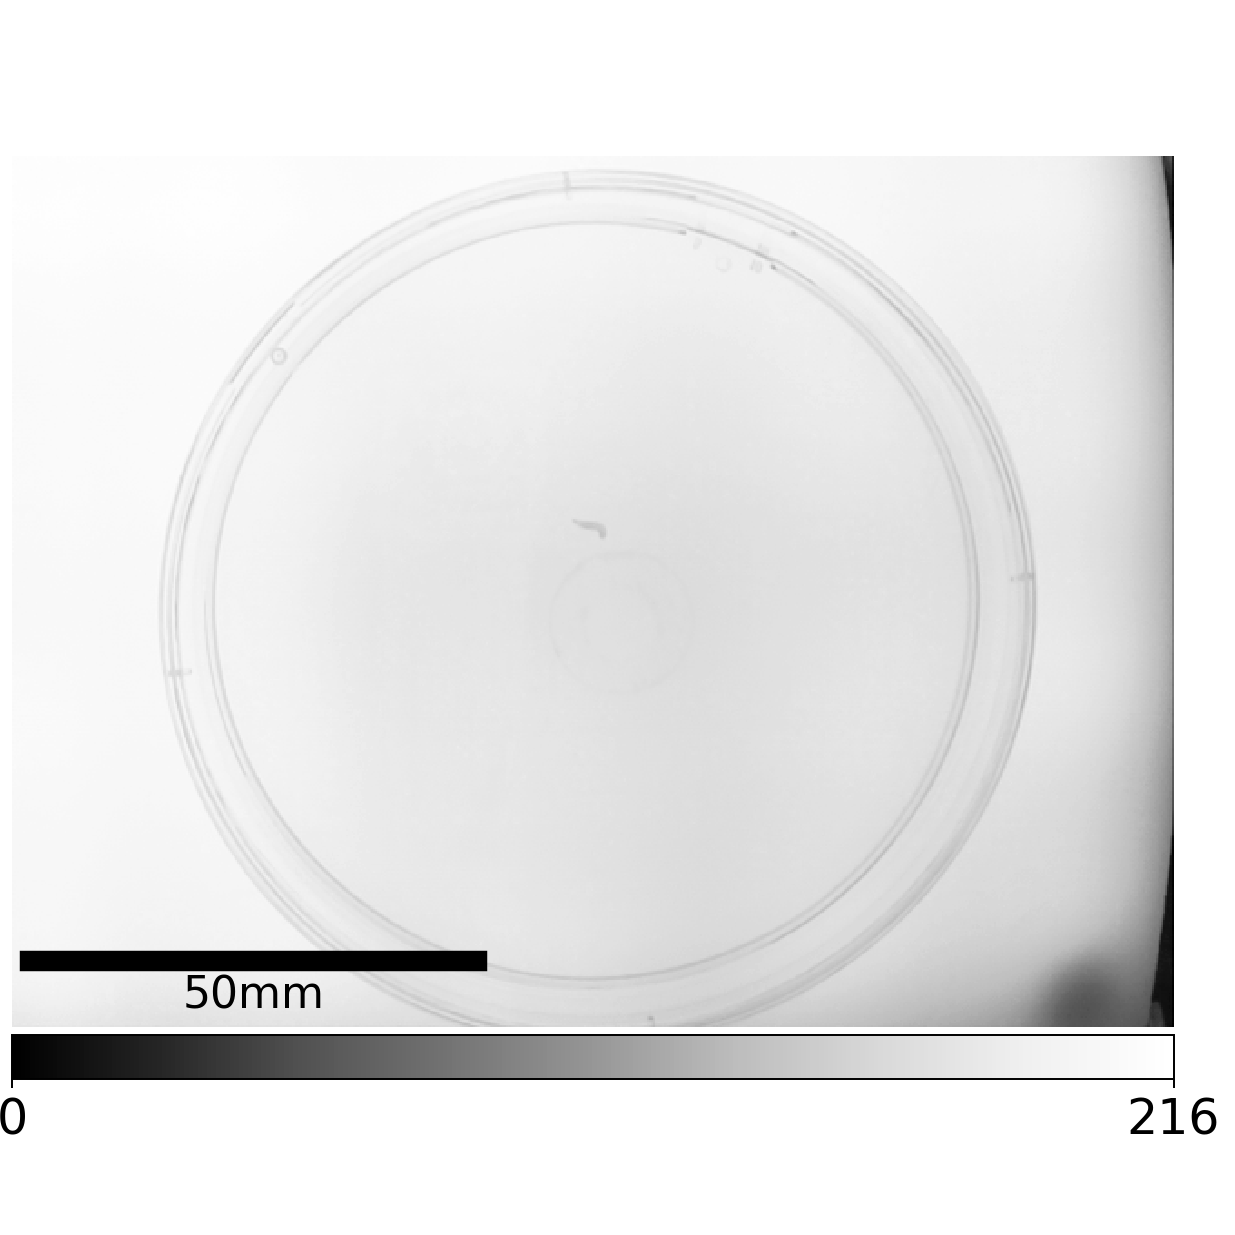

In [14]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot = ax.imshow(all_images[:,:,starting_point], 'Greys_r')
ax.axis('off')

# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot, 
                  orientation="horizontal", 
                  ticks=[np.amin(all_images[:,:,starting_point]),
                         np.amax(all_images[:,:,starting_point])], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([np.amin(all_images[:,:,starting_point]),
                         np.amax(all_images[:,:,starting_point])], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40

fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           50*pixel_per_mm, '50mm', 
                           'lower left',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=10,
                           fontproperties=fontprops)
ax.add_artist(scalebar) 

#fig.tight_layout()
fig.subplots_adjust(left=0.01, bottom=0, top=1, right=0.95) # !!!
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3a_FirstImage.eps')

<IPython.core.display.Javascript object>


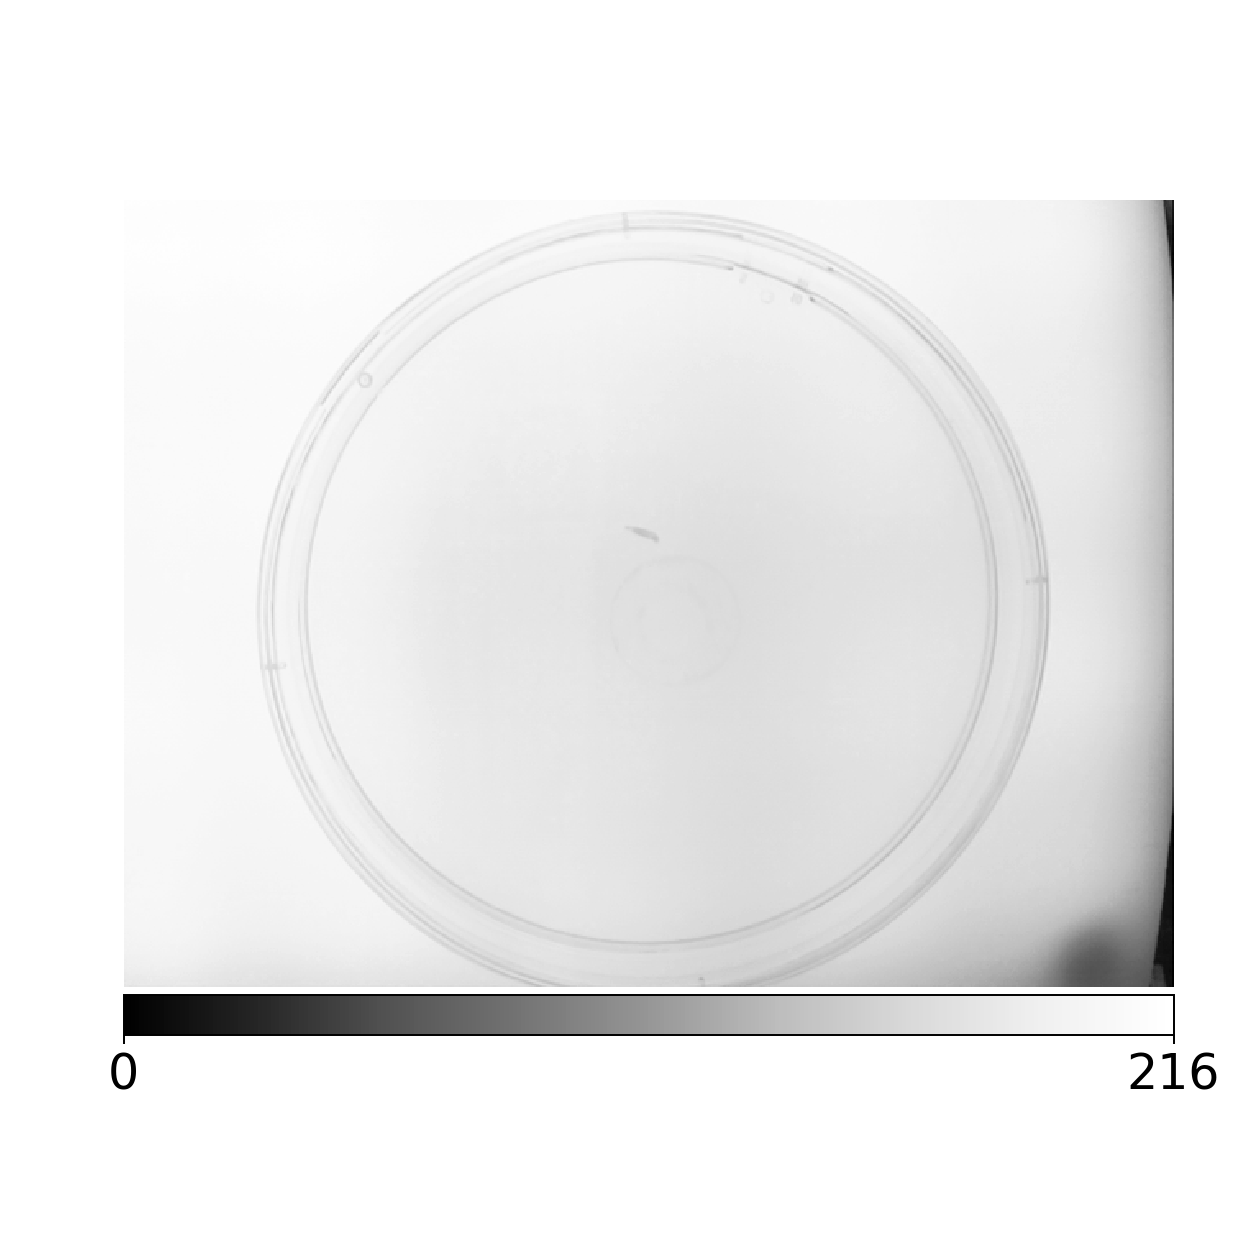

In [15]:
filtered_images = np.zeros((all_images.shape[0],all_images.shape[1],2))
filtered_images[:,:,0] = ndimage.gaussian_filter(all_images[:,:,starting_point],sigma=sigma_for_image_filtering)
filtered_images[:,:,1] = ndimage.gaussian_filter(all_images[:,:,starting_point+1],sigma=sigma_for_image_filtering)
mean_images = np.nanmean(filtered_images,axis=2)

fig=plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot = ax.imshow(all_images[:,:,starting_point+1], 'Greys_r')
ax.axis('off')

# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot, 
                  orientation="horizontal", 
                  ticks=[np.amin(all_images[:,:,starting_point]),
                         np.amax(all_images[:,:,starting_point])], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([np.amin(all_images[:,:,starting_point]),
                         np.amax(all_images[:,:,starting_point])], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40
#fig.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3b_SecondImage.eps')

<IPython.core.display.Javascript object>


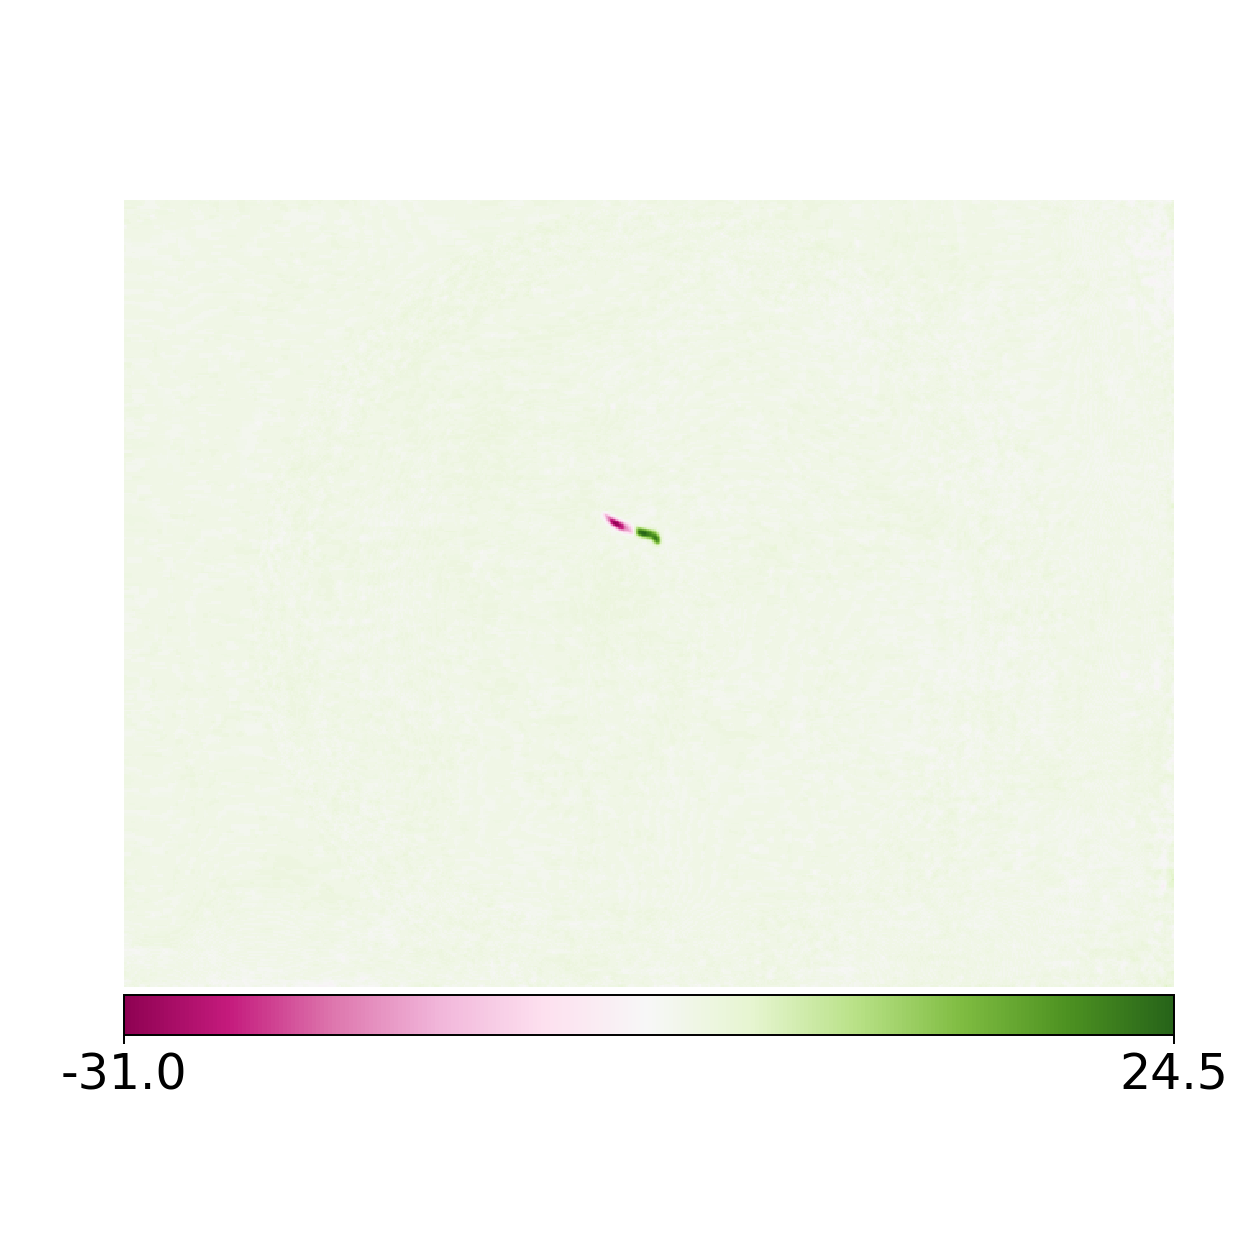

In [16]:
subtracted_image = ndimage.gaussian_filter(all_images[:,:,starting_point+6],sigma=sigma_for_image_filtering).astype(np.int16) - mean_images

fig=plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot = ax.imshow(subtracted_image, 'PiYG')
ax.axis('off')
#fig.tight_layout()
# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot, 
                  orientation="horizontal", 
                  ticks=[np.amin(subtracted_image),
                         np.amax(subtracted_image)], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([np.amin(subtracted_image),
                         np.amax(subtracted_image)], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40
#fig.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3c_SecondSubtractedImage.eps')

<IPython.core.display.Javascript object>


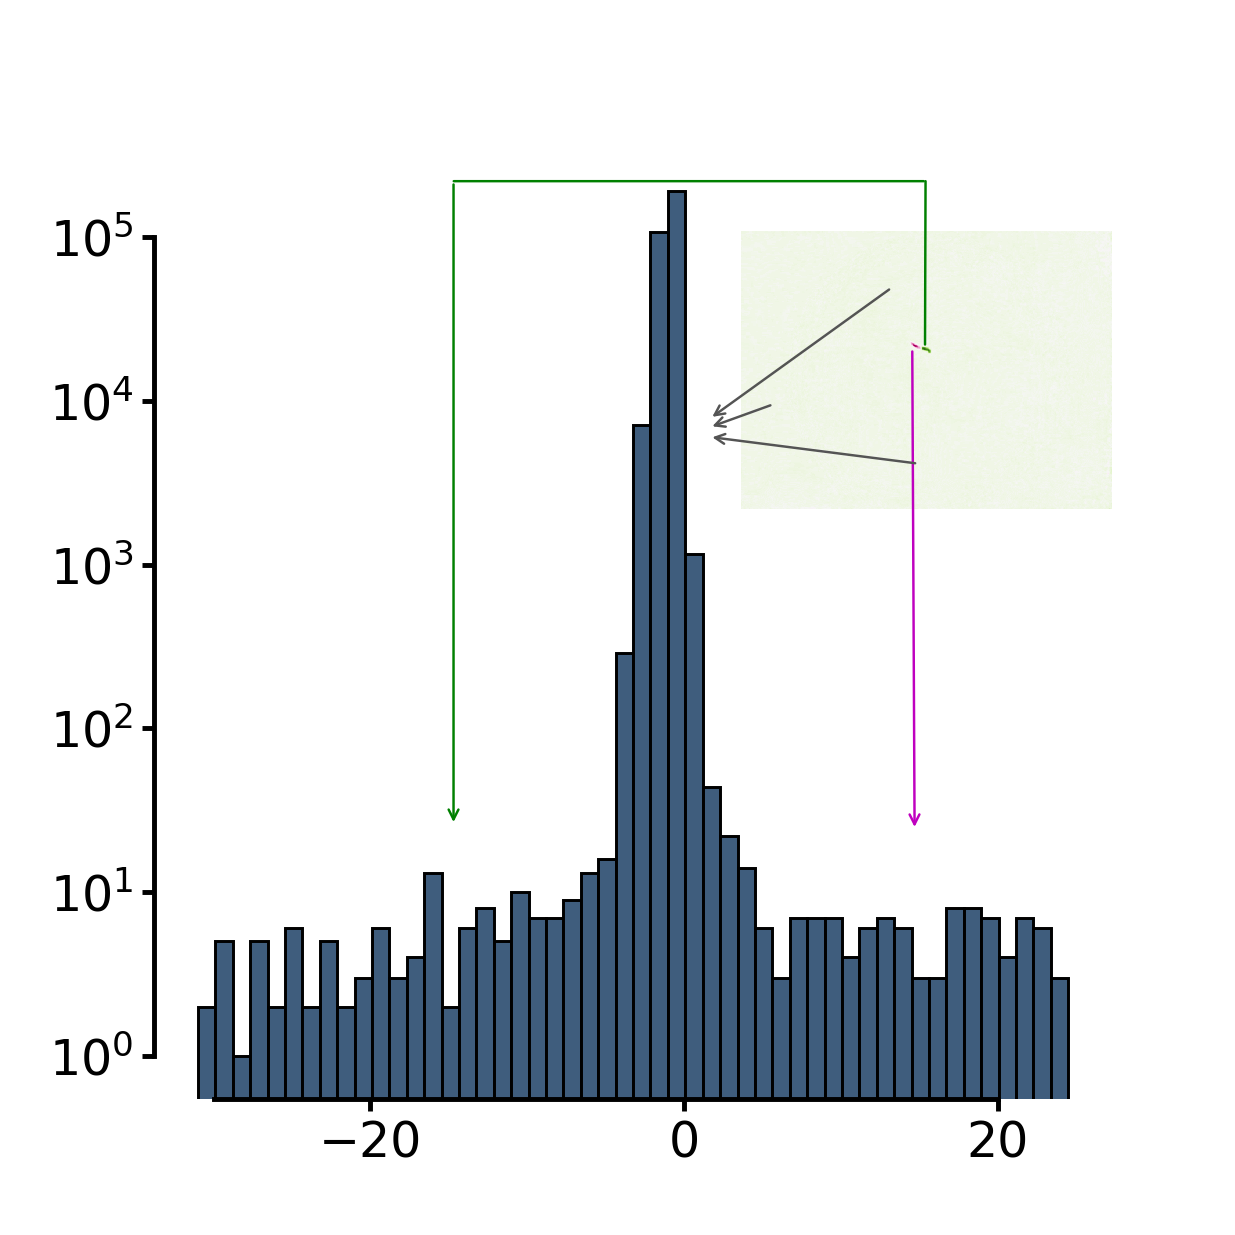

In [17]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)
ax_image = fig.add_axes([0.6,0.5,0.3,0.4])

ax.hist(subtracted_image.ravel(), bins=50,color="#3F5D7D",edgecolor='black', linewidth=1.2,zorder=0)
ax.set_yscale("log", nonposy='clip')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_image.imshow(subtracted_image, 'PiYG',zorder=1)
ax_image.axis('off')


# set the y axis limit
#ax.set_ylim(1,515000)

# POSITIVE VALUES
xyA = (295,207)
xyB = (14.7,25)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=ax_image, axesB=ax, color='m', arrowstyle='->',zorder=2)
ax_image.add_artist(con)

# ZERO VALUES
xyA = (300,400)
xyB = (1.8,6000)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=ax_image, axesB=ax, color='#545454', arrowstyle='->',zorder=2)
ax_image.add_artist(con)
xyA = (50,300)
xyB = (1.8,7000)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=ax_image, axesB=ax, color='#545454', arrowstyle='->',zorder=2)
ax_image.add_artist(con)
xyA = (255,100)
xyB = (1.8,8000)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=ax_image, axesB=ax, color='#545454', arrowstyle='->',zorder=2)
ax_image.add_artist(con)

# NEGATIVE VALUES - bit more complicated
xyA = (317,195)
xyB = (15.4,220000)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                      axesA=ax_image, axesB=ax, color='g', arrowstyle='-',zorder=2)
ax_image.add_artist(con)

# horizontal line
ax.annotate("", xy=(15.6, 220000), xytext=(-15, 220000),arrowprops=dict(arrowstyle="-",color='g'))
# final arrow
ax.annotate("", xy=(-14.7, 225000), xytext=(-14.7, 25),arrowprops=dict(arrowstyle="<-",color='g'))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=2, length =5)
ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)

# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(1, 100000)

ax.spines['bottom'].set_bounds(-30,20)

# turn minor ticks off (make a mess in the illustrator file)
ax.minorticks_off()

os.chdir(home_path)
os.chdir(targetpath)
if save_plots: 
    fig.savefig('Fig1S3d_HistogramMode1.eps')#, rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


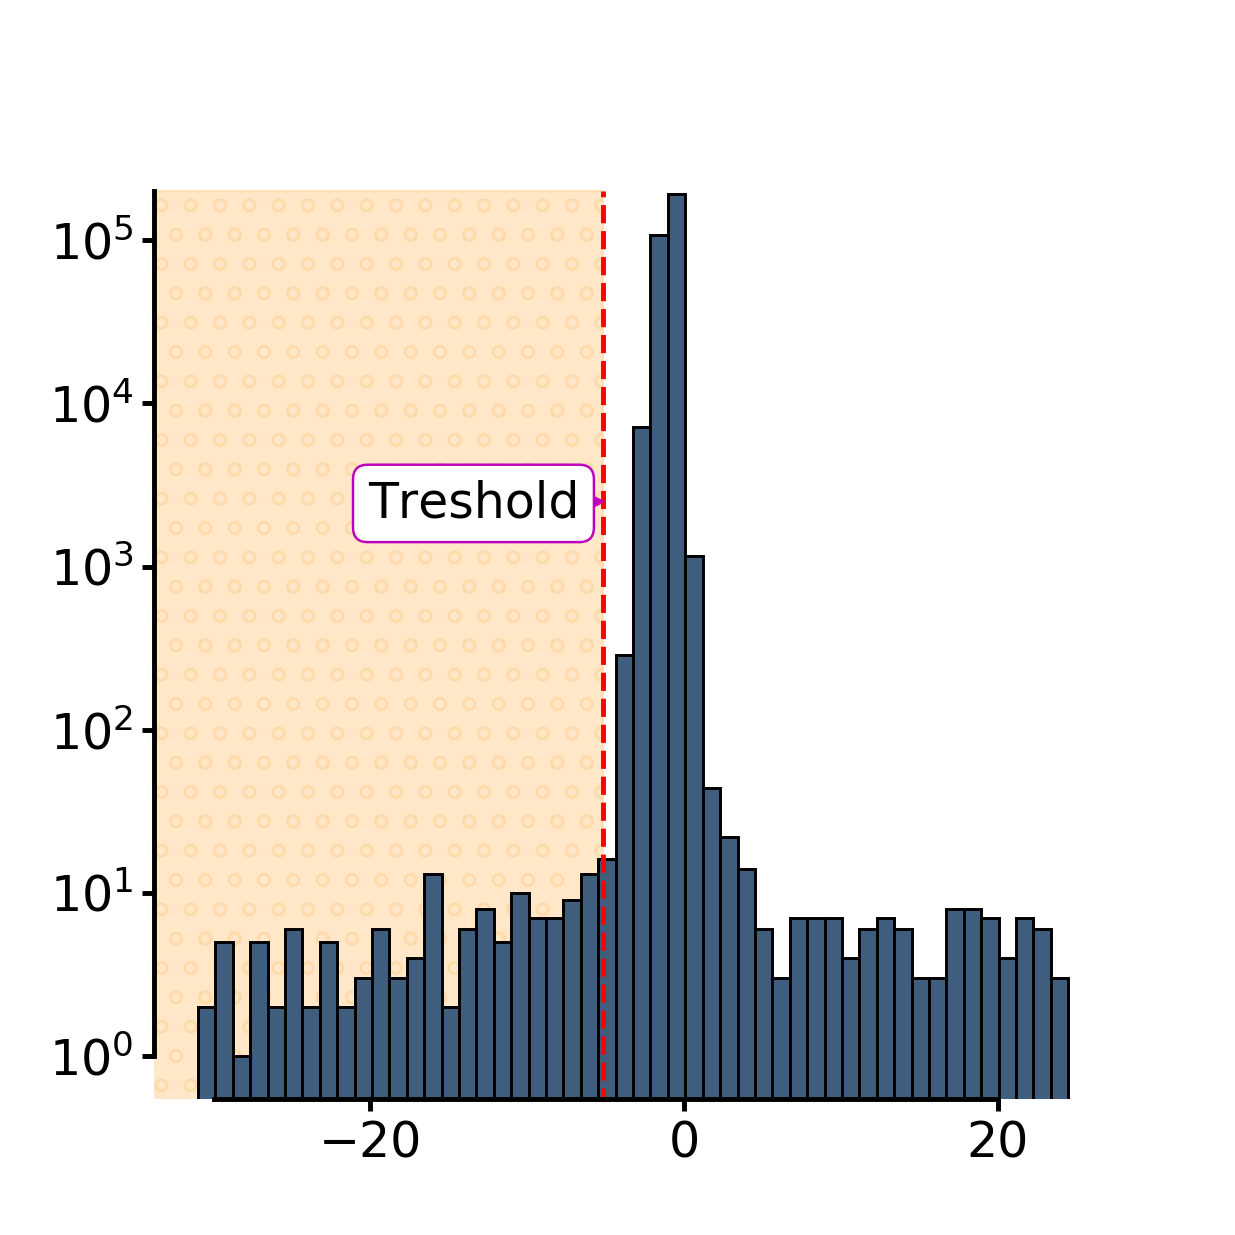

In [18]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

ax.hist(subtracted_image.ravel(), bins=50,color="#3F5D7D",edgecolor='black', linewidth=1.2, zorder=0)
ax.set_yscale("log", nonposy='clip')

ax.plot([np.nanmean(subtracted_image) - 2 * sigma_threshold_before_roi, 
        np.nanmean(subtracted_image) - 2 * sigma_threshold_before_roi], 
        [0,200000], c='r', ls='--', lw=2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=2, length =5)
ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)

# set the y axis limit
#ax.set_ylim(0,270000)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(1, 200000)

ax.spines['bottom'].set_bounds(-30,20)

# draw another rectangle in the background to indicate what the signal will be 
rect = patches.Rectangle((np.nanmean(subtracted_image) - 2 * sigma_threshold_before_roi,0),
                         -255, 
                         200000,linewidth=1,
                         edgecolor='#ffd193ff',facecolor='#ffd193ff', fill=True, alpha = 0.5,
                         hatch='o', label='Signal',zorder=-1)
ax.add_patch(rect)

txt_x_displacement = -15
txt_y_displacement = -500
ax.annotate('Treshold', xy=(np.nanmean(subtracted_image) - 2 * sigma_threshold_before_roi,2500), xycoords='data', 
                  xytext=((np.nanmean(subtracted_image) - 2 * sigma_threshold_before_roi)+txt_x_displacement, 
                        2500+txt_y_displacement), 
            arrowprops=dict(arrowstyle="simple", color='m'), size=20,
                  bbox=dict(boxstyle="round", fc="w", ec="m"))


# turn minor ticks off (make a mess in the illustrator file)
ax.minorticks_off()

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3e_HistogramMode1Tresh.eps')#, rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


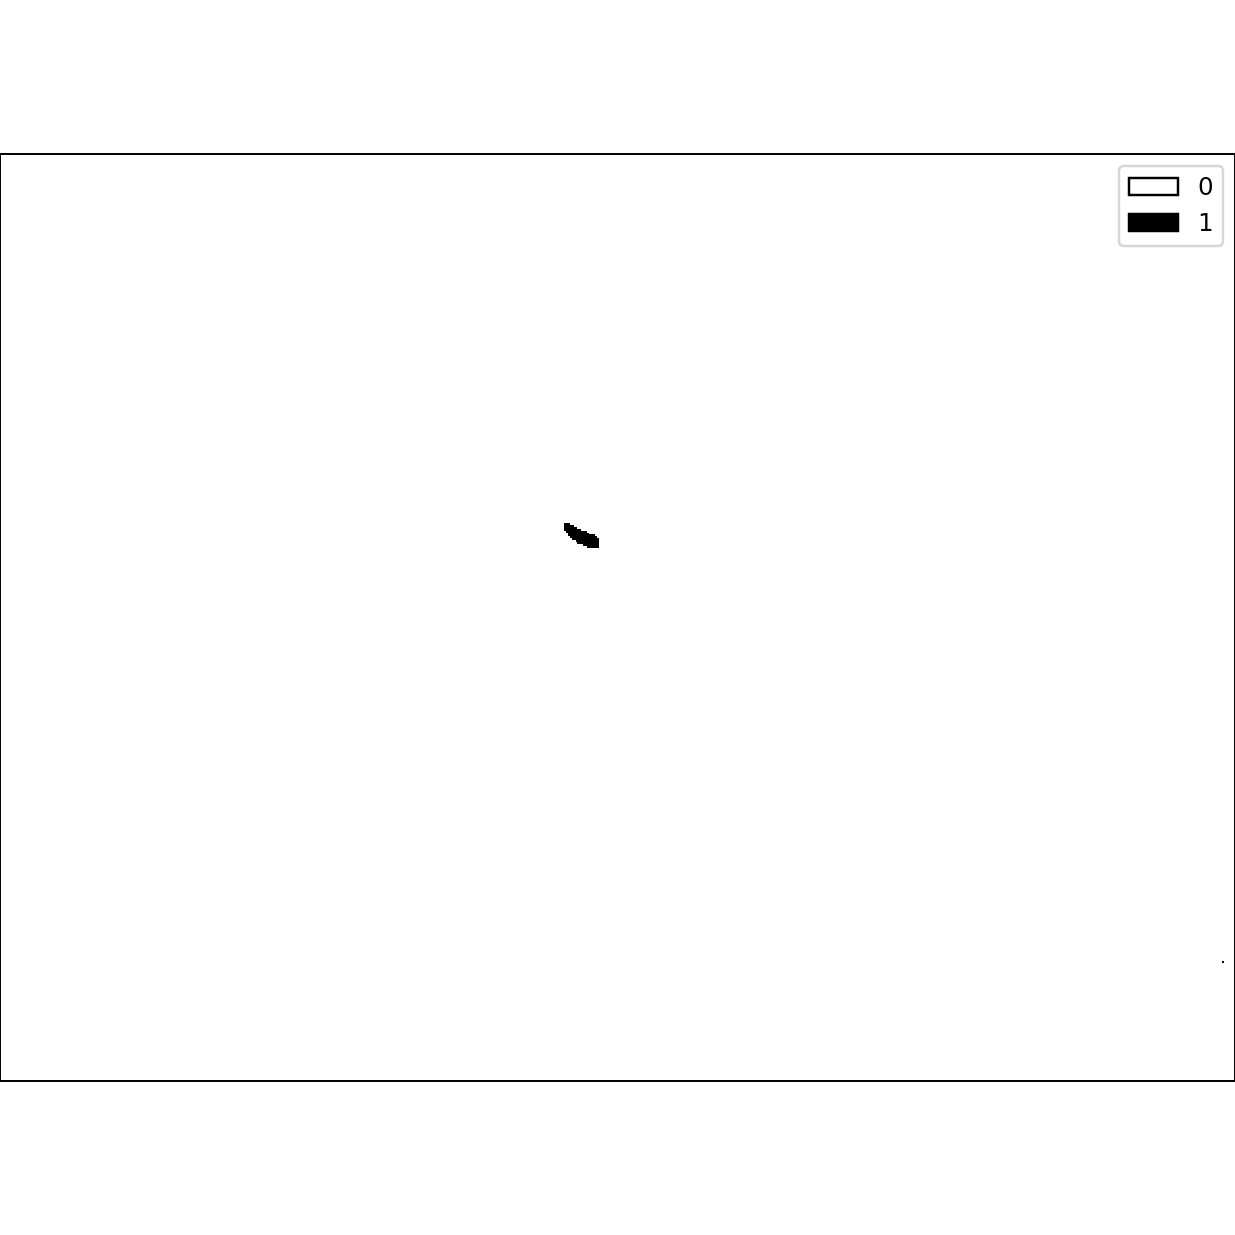

In [19]:
binary = subtracted_image < np.nanmean(subtracted_image) - 2 * sigma_threshold_before_roi
# convert from boolean to int array! Just for plotting of colorbar
binary = binary.astype(np.uint8)

fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(111)

plot = ax.imshow(binary,'Greys')
ax.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 
'''
#fig.tight_layout()
# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot, 
                  orientation="horizontal", 
                  ticks=[np.amin(binary),
                         np.amax(binary)], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([np.amin(binary),
                         np.amax(binary)], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40
fig.subplots_adjust(left=0.1, bottom=0, top=1, right=0.95) # !!!
#fig.tight_layout()
'''

# create custom legend
legend_elements = [patches.Patch(facecolor='white', edgecolor='k',label='0'),
                   patches.Patch(facecolor='k', edgecolor='k',label='1')]
ax.legend(handles=legend_elements)

fig.subplots_adjust(left=0, bottom=0, top=1, right=1) # !!!
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3f_Mode1Binary.eps')

In [20]:
"""
Identification of the original region of interest (ROI):

This function identifies a region in the image that contains pixels that change over time. The assumption is
that the only object moving in the field of view should be the animal the user is interested in.

To achieve this, the camera provides images. This function will take the mean of the images taken so far. It
will then, starting from the second frame, start to subtract the newest frame from the previously taken images.
In the resulting image, anything that moves will clearly stand out compared to the background. A region of
interest is then drawn around those pixels to be used later on.

"""

#try:
identification_images = None
roi_found = False
counter = 0
Raspberry = False
sigma_for_image_filtering = 2.5
#filled_area_min = 10
'''
pixel_per_mm=3.82
fps=30
filled_area_min_mm=3
filled_area_min = filled_area_min_mm * pixel_per_mm
filled_area_max_mm=150
filled_area_max = filled_area_max_mm* pixel_per_mm
eccentricity_min=0
eccentricity_max=1.0
major_over_minor_axis_min=1
major_over_minor_axis_max=10
max_skeleton_length_mm=20
max_skeleton_length = max_skeleton_length_mm * pixel_per_mm
max_speed_animal_mm_per_s=150


boxsize = (max_speed_animal_mm_per_s / int(fps) * pixel_per_mm)
boxsize = boxsize + (max_skeleton_length_mm * pixel_per_mm)
'''
"""
This function runs as long until it finds something that could be the animal - if debug mode is on, the user
will be asked if that's ok - if not it's called again to keep looking.
The more images have to be taken the lower the background will be as the images mean is taken and the more
clear the moving animal should be visible.
"""
while roi_found == False :
    print('counter: ' + repr(counter))

    blobs = []

    if counter == 0:
        # immediately filter the image using a gaussian filter to get rid of camera noise
        first_image = ndimage.filters.gaussian_filter(all_images[:,:,counter],
                                                           sigma=sigma_for_image_filtering)
        unfiltered_background = all_images[:,:,counter].copy()

        goodbackground = first_image.copy()
        #self.identification_images = np.zeros((self.first_image.shape[0], self.first_image.shape[1],20),
        #                                 dtype=np.uint8) # 20 frames must be enough to find something moving of course depends on the framerate!
        # On the raspberry this usually takes quite a while as no matter the fps asked by the user, it will
        # almost certainly be lower as the operation needs to be done on the whole image (usually 2fps or so)
        # We assume that most animals move after 10-20 seconds

        # If, on the other hand, someone takes a video at a high framerate, e.g. at 80fps, it's quite
        # possible that the animal does not move in the first half second. It's impossible to determine
        # exactly how many frames should be preallocated, but 500 frames of 1024x784 is ~50Mb, so this should
        # work even on PCs with essentially no RAM.
        preallocated_images = 500
        identification_images = np.zeros((first_image.shape[0], first_image.shape[1],
                                               preallocated_images),
                                         dtype=np.uint8)

        identification_images[:,:,0] = first_image

    elif counter > 0 :

        # this really shouldn't happen on the RasbperryPi. It might happen when the user records a high-speed
        # video of an animal that doesn't move a lot (or very sporadically). This is NOT a very efficient way
        # to to preallocate the array as the old array together with a newly allocated array needs to be copied
        # to a new location in memory. This will make consecutive operations faster, however.
        if counter % preallocated_images == 0 and counter != 0:
            identification_images = np.dstack((identification_images,
                                                   np.zeros((first_image.shape[0], first_image.shape[1],
                                                             preallocated_images))
                                                    )).copy()


        # immediately use a gaussian filter on that image and save it
        identification_images[:,:,counter] = \
            ndimage.filters.gaussian_filter(all_images[:,:,counter],
                                            sigma=sigma_for_image_filtering)


        # take the mean of all the images taken so far
        image_mean = np.nanmean(identification_images[:, :, 0:counter], axis=2)
        # idea to speed up if many images are being taken
        # subtract the current image from the mean image
        subtracted_image = identification_images[:, :, counter] - image_mean

        # now we should have a trimodal distribution of pixel intensity. We just take mean of the
        # smoothened image - a given factor * the standard deviation subtracted, unsmoothened image

        locate_thresh = np.nanmean(subtracted_image) - 2 * sigma_for_image_filtering
        thresh_image = subtracted_image < locate_thresh


        # regionprops will be used throughout the tracking software:
        # http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
        props = regionprops(label(thresh_image))
        # in case we have more than one regionproperty
        if len(props) > 1:
            # go through all of them
            for i_props in range(len(props)):

                # 3 rules at the moment: 1) the are must be in a certain range. 2) The eccentrecity
                # (='roundness') must be in a certain range (e.g. it shouldn't be a circle) and
                # 3) the major axis / minor axis must be in a certain range
                # maybe can kick out the eccentricity? Major/minor is more intuitive.
                if filled_area_min < props[i_props].filled_area <  filled_area_max and \
                        eccentricity_min  < props[i_props].eccentricity < eccentricity_max and \
                        major_over_minor_axis_min < \
                        props[i_props].major_axis_length/props[i_props].minor_axis_length < \
                        major_over_minor_axis_max:
                    blobs.append(i_props)

            # if there's only one regionprop, perfect, found the moving object
            if len(blobs) == 1:
                # Call the FindROI function with boxsize + the skeleton length. Necessary for slow animals,
                # such as larvae
                first_roi = FindROI(props[blobs[0]], boxsize + organisms_and_heuristics[
                    model_organism]['max_skeleton_length_mm']*pixel_per_mm, 2, first_image)
                roi_found = True
                print('only one blob at x:' + repr(props[blobs[0]].centroid[1])[0:4] + ' y: ' +
                      repr(props[blobs[0]].centroid[0])[0:4])
                # Temporarily  save these parameters for display in messagebox if debug mode is on
                filled_area = props[blobs[0]].filled_area
                eccentricity = props[blobs[0]].eccentricity
                major_over_minor = props[blobs[0]].major_axis_length / props[blobs[0]].minor_axis_length
            # otherwise the animal hasn't moved enough yet, or too many things moved,
            # so try again with another picture
            else:
                pass

        # if there's only one regionprop, and if it's bigger than a defined minimum, perfect, found the animal
        elif len(props) == 1:
            if props[0].area > filled_area_min:
                # If there's only one blob and it makes the cut for size, try to take the object and say this
                # is the animal we're looking for
                first_roi = FindROI(props[0], boxsize + max_skeleton_length_mm*pixel_per_mm, 2, first_image)

                roi_found = True
                # Temporarily  save these parameters for display in messagebox if debug mode is on
                filled_area = props[0].filled_area
                eccentricity = props[0].eccentricity
                major_over_minor = props[0].major_axis_length / props[0].minor_axis_length
                print('only one prop')
        # otherwise try again next picture
        elif len(props) == 0:
            pass
        
    counter +=1


counter: 0
counter: 1
counter: 2
only one prop


C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


<IPython.core.display.Javascript object>


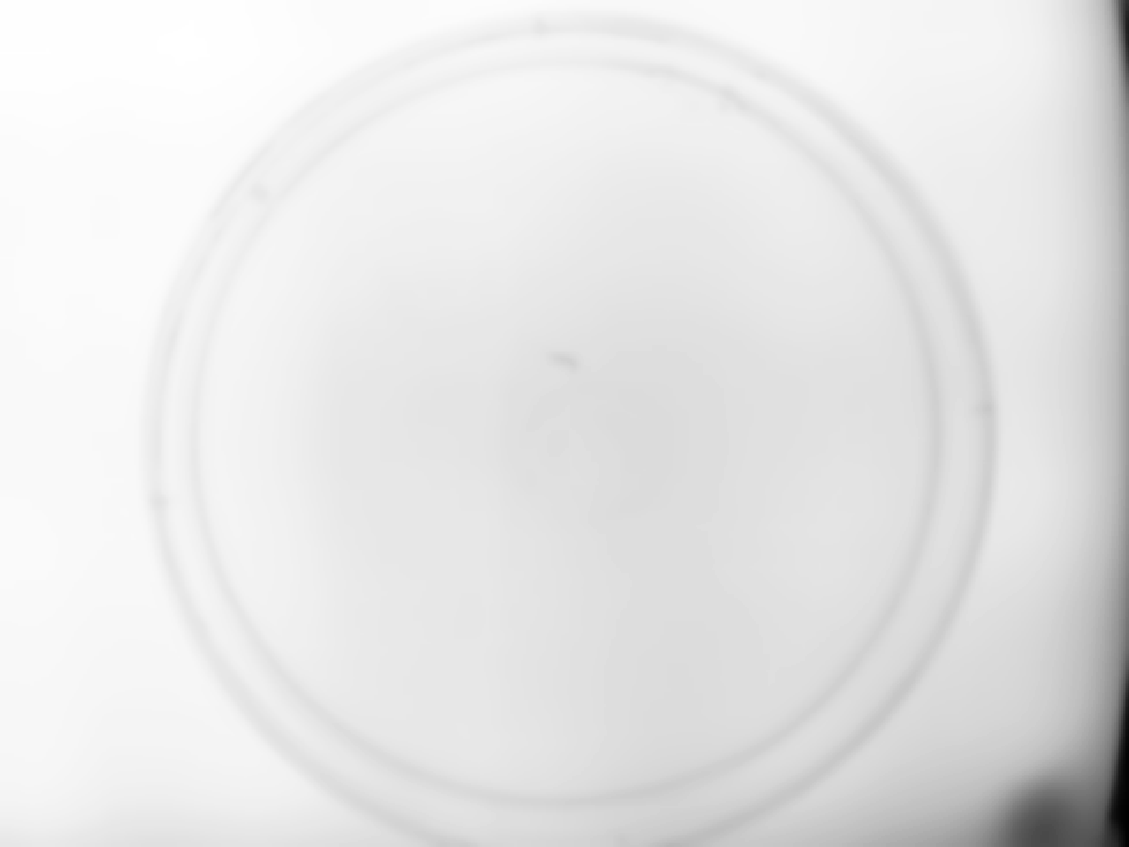

In [21]:
smoothened_background = ndimage.filters.gaussian_filter(goodbackground,sigma=1)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(smoothened_background,'Greys_r')
ax.axis('off')
fig.subplots_adjust(left=0, bottom=0, top=1, right=1) # !!!
os.chdir(home_path)
os.chdir(targetpath)
#fig.savefig(targetpath + 'Mode1Background.png')

<IPython.core.display.Javascript object>


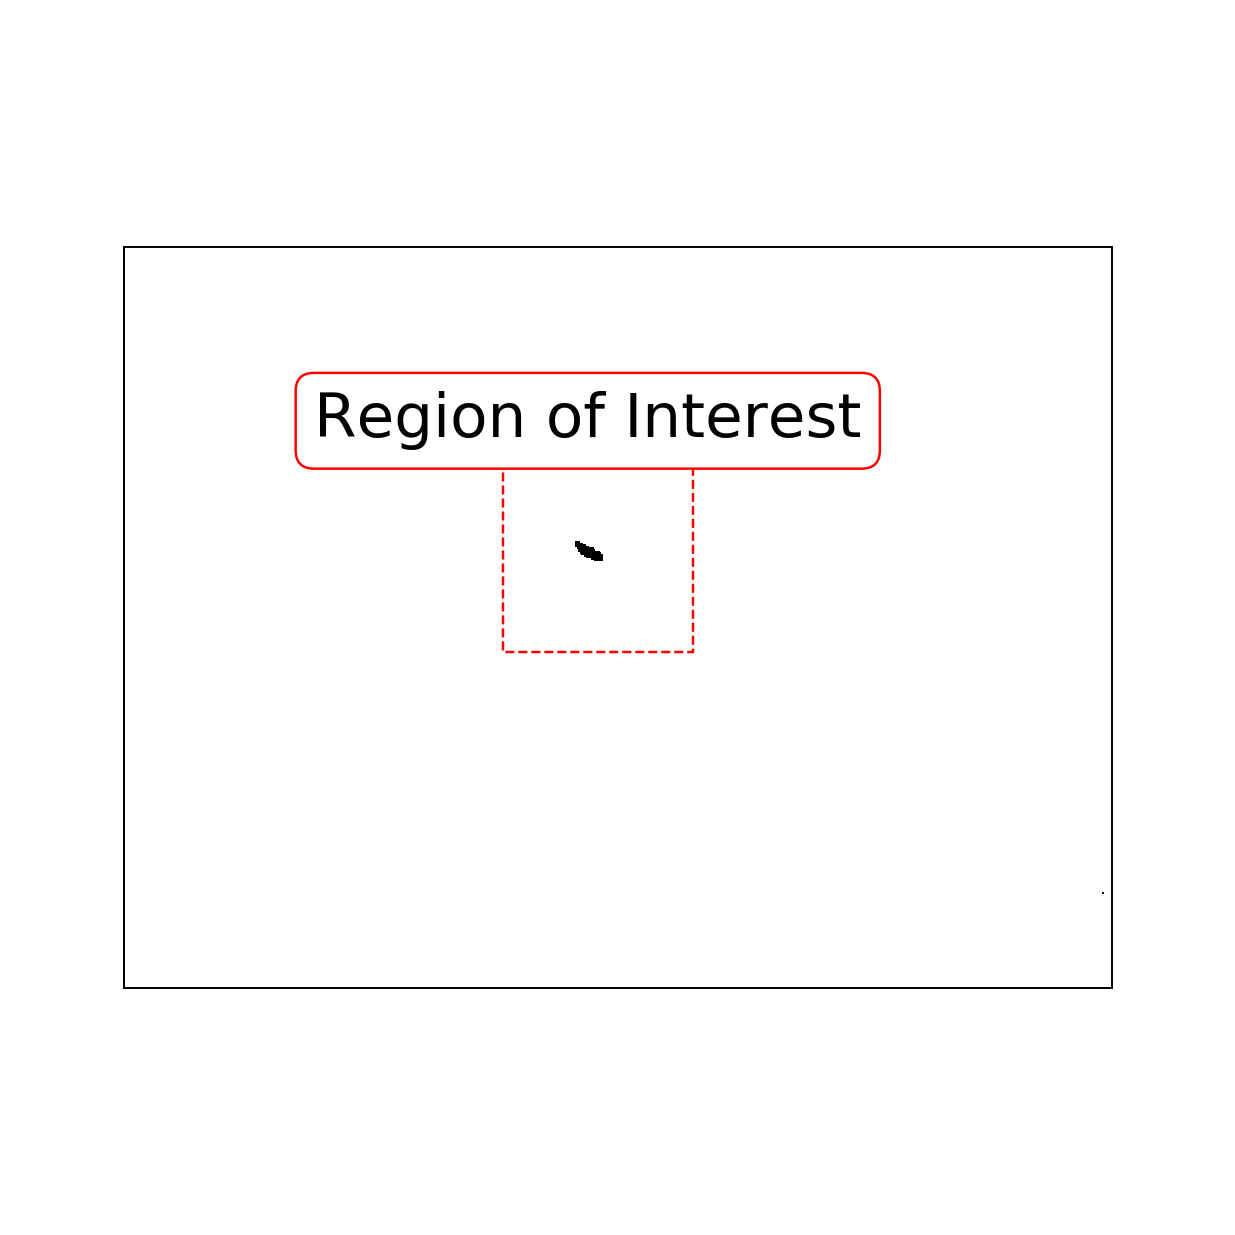

In [22]:
# Same as binary, but showing the area that the algorithm 'focuses on' for now
#x_position_inset, y_position_inset = 0.4,0.2
#width_inset, height_inset = 0.3,0.3

fig=plt.figure(figsize=(7,7))
# create the large axis
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# create the inset
#ax2 = fig.add_axes([x_position_inset, y_position_inset, width_inset, height_inset])
#ax2.axis('off')

ax.imshow(binary,'Greys')
ax.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 

# inset
#ax2.imshow(all_images[int(first_roi.row_min):int(first_roi.row_max), 
#                  int(first_roi.col_min):int(first_roi.col_max),starting_point], cmap='Greys_r')
# Create a Rectangle patch
rect = patches.Rectangle((first_roi.col_min,first_roi.row_min ),
                         first_roi.row_max - first_roi.row_min,
                         first_roi.col_max - first_roi.col_min,
                         linewidth=1,edgecolor='r',facecolor='none',ls='--')
ax.add_patch(rect)
ax.annotate('Region of Interest', xy=(first_roi.col_min, first_roi.row_min), xycoords='data', 
                  xytext=(first_roi.row_max - first_roi.row_min, 
                          first_roi.col_max - first_roi.col_min), 
            arrowprops=dict(arrowstyle="simple", color='r'), size=25,
                  bbox=dict(boxstyle="round", fc="w", ec="r"))

fig.subplots_adjust(left=0, bottom=0, top=1, right=1) # !!!
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3g_ROI.eps')

<IPython.core.display.Javascript object>


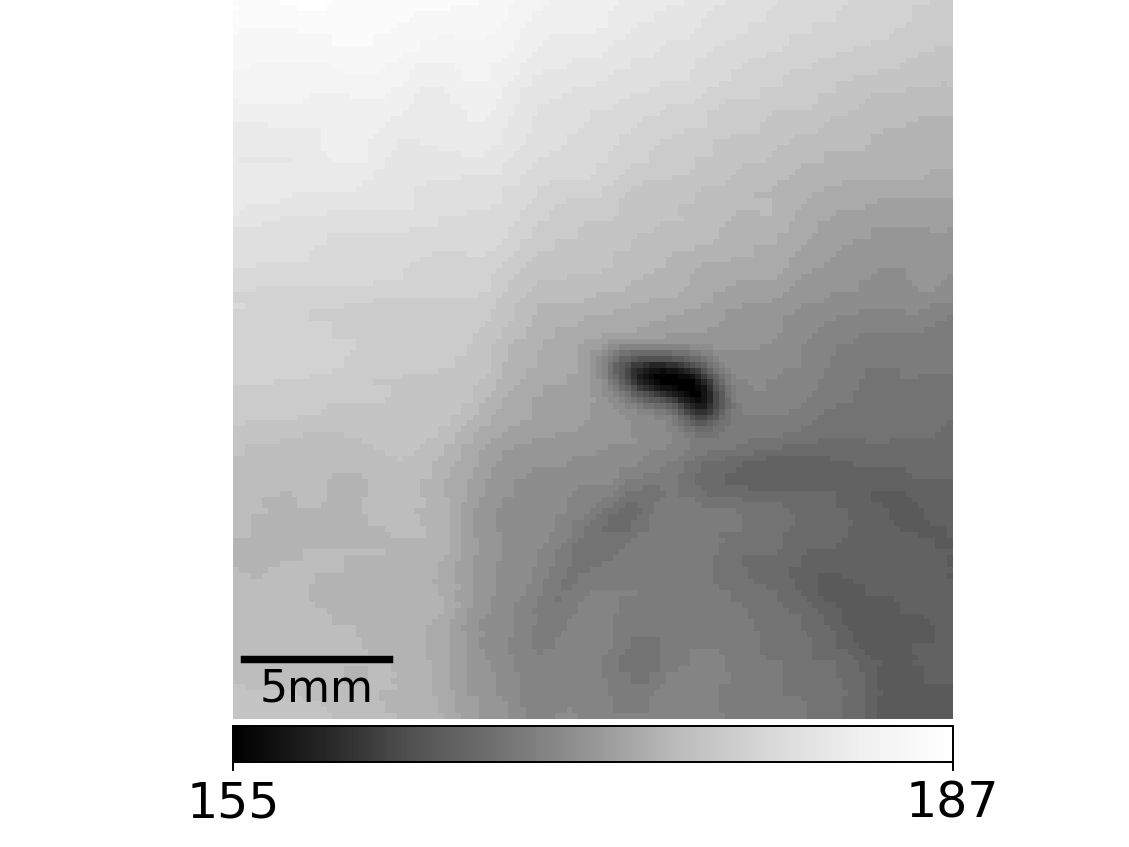

In [23]:
# plot the region of interest (first Image)
image_roi = first_image[int(first_roi.row_min):int(first_roi.row_max), 
                     int(first_roi.col_min):int(first_roi.col_max)]

fig = plt.figure()
ax = fig.add_subplot(111)
plot = ax.imshow(image_roi,cmap='Greys_r')
ax.axis('off')

# get the colorbar exactly the same size as the resulting window!
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad='1%')
# add colormap to explain the heatmap, control how many ticks using the ticks parameter
cbar=fig.colorbar(plot, 
                  orientation="horizontal", 
                  ticks=[np.amin(image_roi),
                         np.amax(image_roi)], 
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)
ticklabs = cbar.ax.get_xticklabels()
cbar.ax.set_xticklabels([np.amin(image_roi),
                         np.amax(image_roi)], fontsize=20)
cbar.ax.get_xaxis().labelpad = -40
fig.subplots_adjust(left=0.1, bottom=0.1, top=1, right=0.95) # !!!
#fig.subplots_adjust(left=0, bottom=0, top=1, right=1) # !!!
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           5*pixel_per_mm, '5mm', 
                           'lower left',
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax.add_artist(scalebar) 

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3h_ROI_Raw.eps')

In [24]:
smooth_current_image = ndimage.gaussian_filter(all_images[:,:,counter], sigma=1)

smooth_subtracted_image = smoothened_background.astype(np.int16) - \
                          smooth_current_image.astype(np.int16)

std = np.std(smooth_subtracted_image)

thresh_image = smooth_subtracted_image < locate_thresh

animal_properties = regionprops(
            label(CallImageROI(thresh_image, first_roi).small_image))

<IPython.core.display.Javascript object>


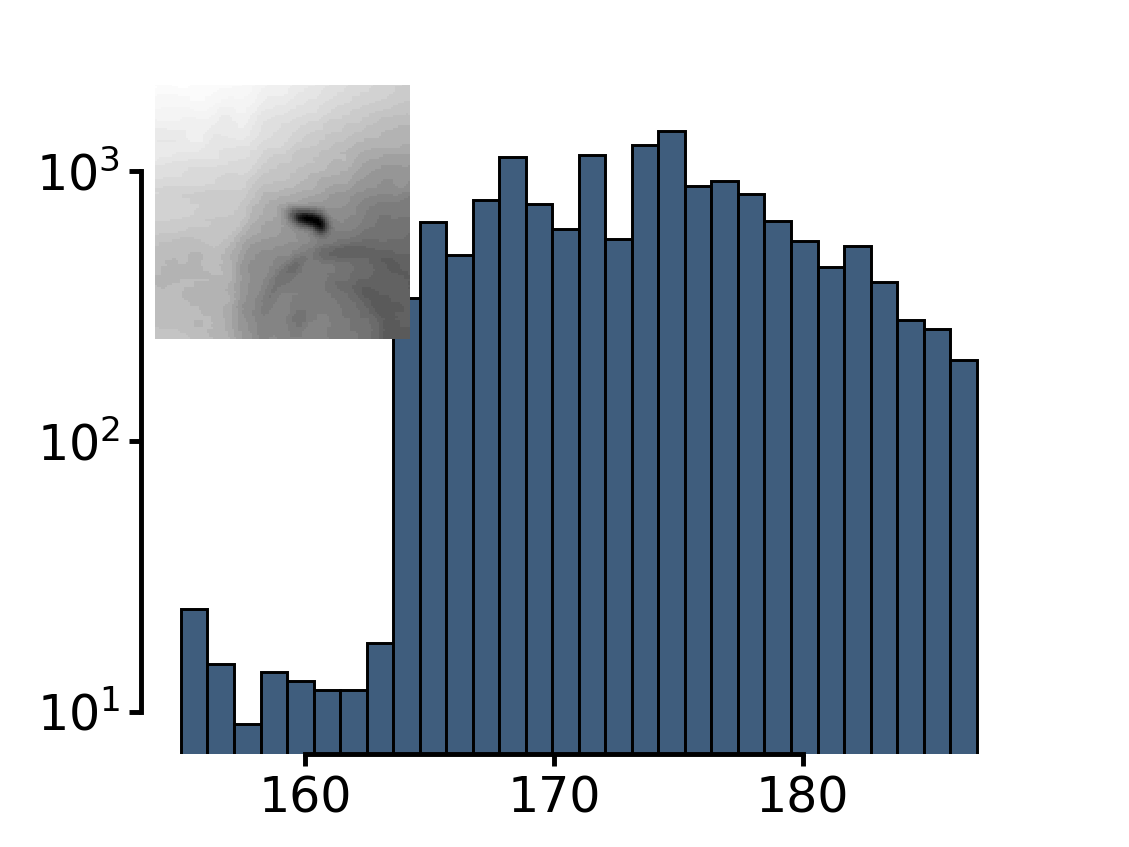

In [25]:
# plot histogram of ROI

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

ax_image = fig.add_axes([0.1,0.6,0.3,0.3])

ax.hist(first_image[int(first_roi.row_min):int(first_roi.row_max),
                  int(first_roi.col_min):int(first_roi.col_max)].ravel(), 
                  bins=30,color="#3F5D7D",edgecolor='black', linewidth=1.2, zorder=0)
ax.set_yscale("log", nonposy='clip')

ax_image.imshow(first_image[int(first_roi.row_min):int(first_roi.row_max), 
                     int(first_roi.col_min):int(first_roi.col_max)],cmap='Greys_r',zorder=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_image.axis('off')
#ax_image.tick_params(
#    axis='both',          # changes apply to the both axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    left=False,         # ticks along the left edge are off
#    labelbottom=False,
#    labelleft=False) 


# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=2, length =5)
ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='y', labelsize=20)

# Can change ticklabel size here, if necessary!
ax.tick_params(axis='x', labelsize=20)

# set the y axis limit
#ax.set_ylim(0,270000)
# Only draw spine between the y-ticks
ax.spines['left'].set_bounds(10, 1000)

ax.spines['bottom'].set_bounds(160,180)
# turn minor ticks off (make a mess in the illustrator file)
ax.minorticks_off()

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3i_ROI_histogram.eps')#,rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


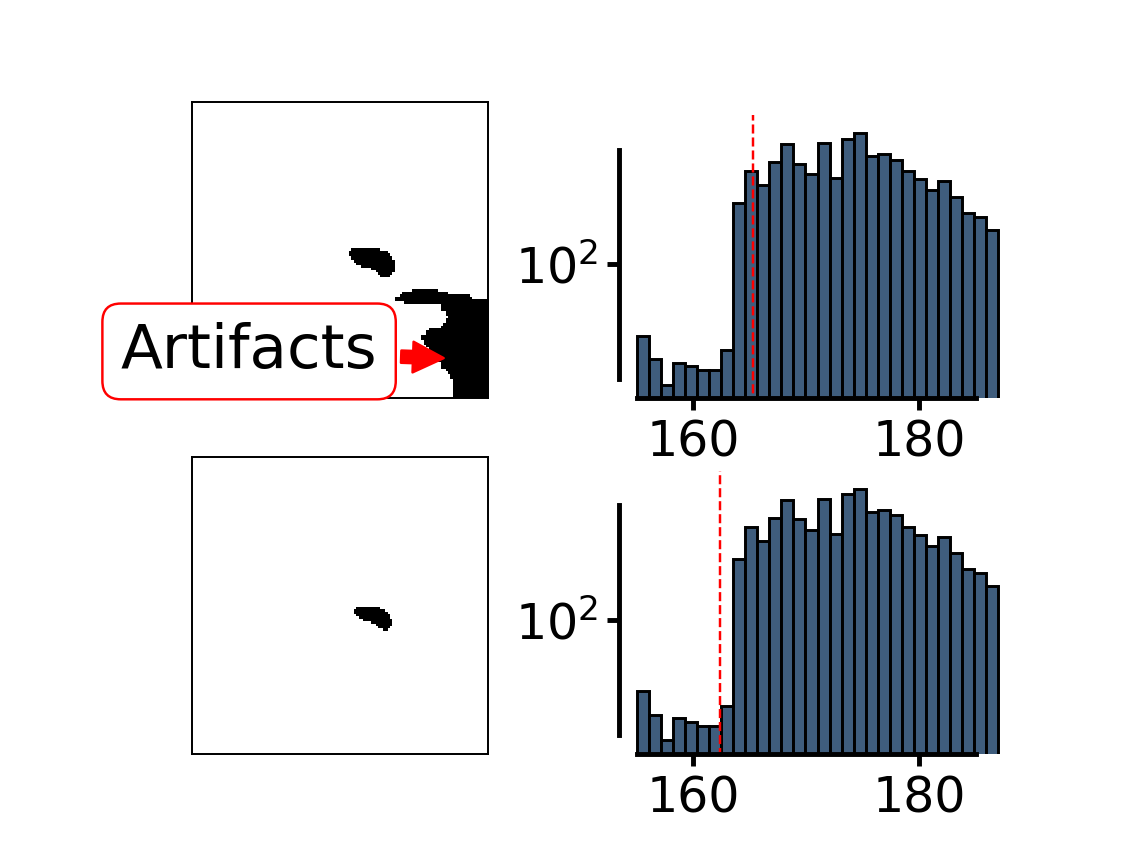

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [26]:
# plot histogram of ROI, indicate different STDs

fig = plt.figure()
ax = fig.add_subplot(222)
def plot_histogram(axis, data):
    axis.set_rasterization_zorder(1)

    axis.hist(data,bins=30,color="#3F5D7D",edgecolor='black', linewidth=1.2, zorder=0)
    axis.set_yscale("log", nonposy='clip')

    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

    # We change the fontsize of minor ticks label 
    axis.tick_params(axis='both', which='major', width=2, length =5)
    axis.tick_params(axis='both', which='minor', width =2,length =3)
    axis.spines['bottom'].set_linewidth(2)
    axis.spines['left'].set_linewidth(2)

    # Can change ticklabel size here, if necessary!
    axis.tick_params(axis='y', labelsize=20)

    # Can change ticklabel size here, if necessary!
    axis.tick_params(axis='x', labelsize=20)

    # set the y axis limit
    #ax.set_ylim(0,270000)
    # Only draw spine between the y-ticks
    axis.spines['left'].set_bounds(10, 1000)

    axis.spines['bottom'].set_bounds(155,185)
    # turn minor ticks off (make a mess in the illustrator file)
    axis.minorticks_off()

# First, show a plot where the threshold isn't set properly and see the consequences on the binary image
first_STD = MeanThresh(first_image, signal, 1.5, first_roi).thresh
plot_histogram(axis = ax, 
               data = first_image[int(first_roi.row_min):int(first_roi.row_max),
                      int(first_roi.col_min):int(first_roi.col_max)].ravel())
ax.plot([first_STD, first_STD], [0,2000], c='r', ls='--',lw=1)

# plot first binary
thresholded_first_STD = first_image[int(first_roi.row_min):int(first_roi.row_max),
                     int(first_roi.col_min):int(first_roi.col_max)] < first_STD

# After showing that a lower STD doesn't lead to a clean image, define a better STD (here manually

second_STD = MeanThresh(first_image, signal, 2, first_roi).thresh

ax2 = fig.add_subplot(221)
ax2.imshow(thresholded_first_STD, cmap='Greys')
ax2.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 

ax2.annotate('Artifacts', xy=(106, 106), xycoords='data', 
                  xytext=(-30,110), 
            arrowprops=dict(arrowstyle="simple", color='r'), size=25,
                  bbox=dict(boxstyle="round", fc="w", ec="r"))

# plot the lower right histogram
ax3 = fig.add_subplot(224)
plot_histogram(axis = ax3,
              data = first_image[int(first_roi.row_min):int(first_roi.row_max),
                      int(first_roi.col_min):int(first_roi.col_max)].ravel())
ax3.plot([second_STD, second_STD], [0,2000], c='r', ls='--', lw=1)

# finally, plot the beautiful binary image
ax4 = fig.add_subplot(223)
thresholded_second_STD = operator.lt(first_image[int(first_roi.row_min):int(first_roi.row_max),
                     int(first_roi.col_min):int(first_roi.col_max)],second_STD)
ax4 = fig.add_subplot(223)
ax4.imshow(thresholded_second_STD, cmap='Greys')
ax4.tick_params(
    axis='both',          # changes apply to the both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the left edge are off
    labelbottom=False,
    labelleft=False) 

os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3j_MovingTheSTD.eps')#, rasterized=True, dpi=300)

In [27]:
compare = operator.lt
box_intensity = 0
decrease_STDs = True
STD = 2.5
signal = 'dark'
while decrease_STDs:
    print(STD)
    # call class MeanThresh with the very first image taken, the first ROI identified, the user delivered signal
    # and a standard deviation (STD) of three
    first_thresh = MeanThresh(all_images[:,:,0], signal, STD, first_roi)

    # this is the thresholded first image we'll use for defining the area occupied by the animal
    first_image_thresholded = compare(first_image, first_thresh.thresh)

    # Call the binary image and identify connected regions only in the defined roi - must make sure that
    # the identified blob can indeed be the animal (according to the heuristic rules) or if the STD needs
    # to be decreased - will make detection slower., though. Maybe just manually decrease the STD from 3 to 2
    animal_properties = regionprops(label(CallImageROI(first_image_thresholded, first_roi).small_image))
    if len(animal_properties) > 0:
        print('found at least one blob')
        decrease_STDs = False
    else:
        STD -= 0.1
        print('Found nothing...adjusting to ' + repr(STD) + ' STDs')

# Check all the connected regions and define the largest object as the animal
first_animal = DescribeLargestObject(animal_properties, first_roi, animal_like=True,
                                              filled_area_min=filled_area_min,
                                              filled_area_max=filled_area_max,
                                              eccentricity_min=eccentricity_min,
                                              eccentricity_max=eccentricity_max,
                                              major_over_minor_axis_min=major_over_minor_axis_min,
                                              major_over_minor_axis_max=major_over_minor_axis_max)
# Problem: If the animal is not detected (e.g. because the blob that was moving before does not look like the
# animal according to the saved_variables.json defined animal) it won't fail here but at a later point.
# Not-so-pretty solution: Do something that will fail anyways later, here to make error tracing more intuitive!
print('first_animal.animal_like_object_detected ' + repr(first_animal.animal_like_object_detected))
print('Animal defined')

2.5
found at least one blob
self.regionproperties[j_areas].filled_area: 75
self.regionproperties[j_areas].eccentricity: 0.909989992063624
ratio major/minor: 2.411787579115747
found a blob that could be an animal
first_animal.animal_like_object_detected True
Animal defined


<IPython.core.display.Javascript object>


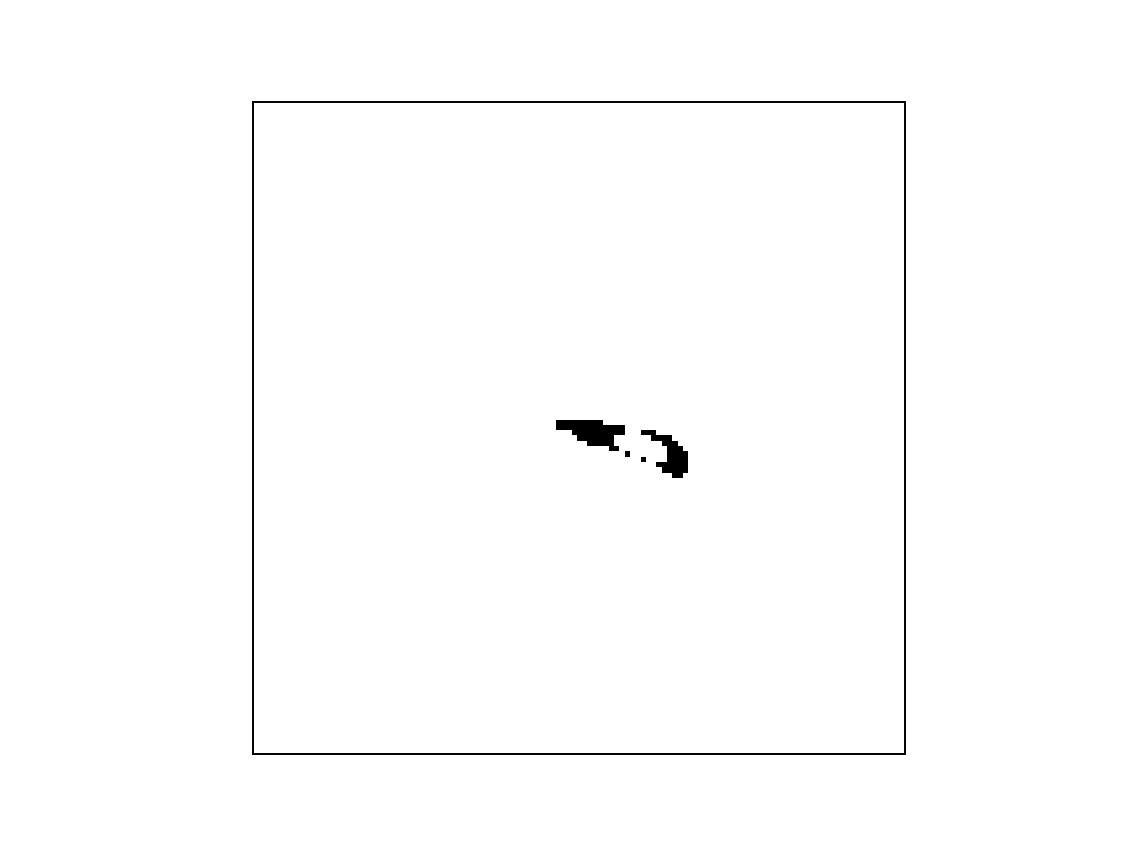

<IPython.core.display.Javascript object>


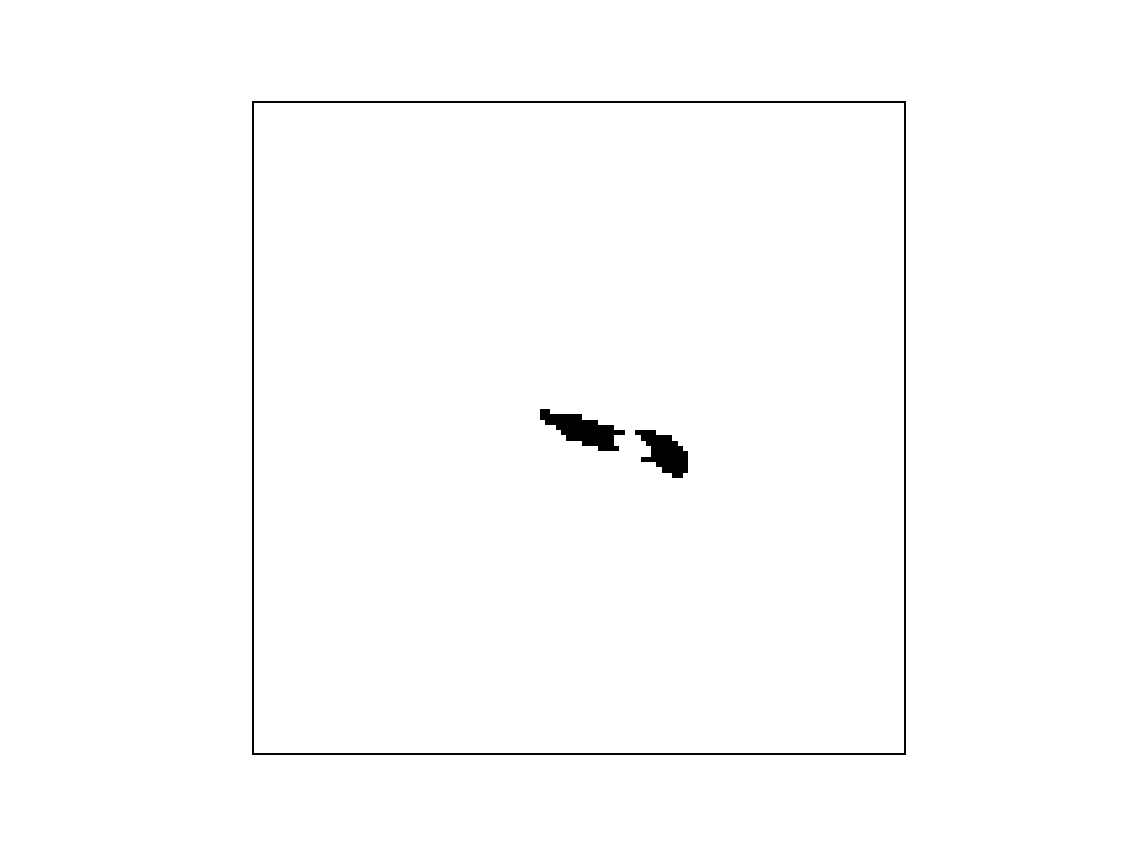

<IPython.core.display.Javascript object>


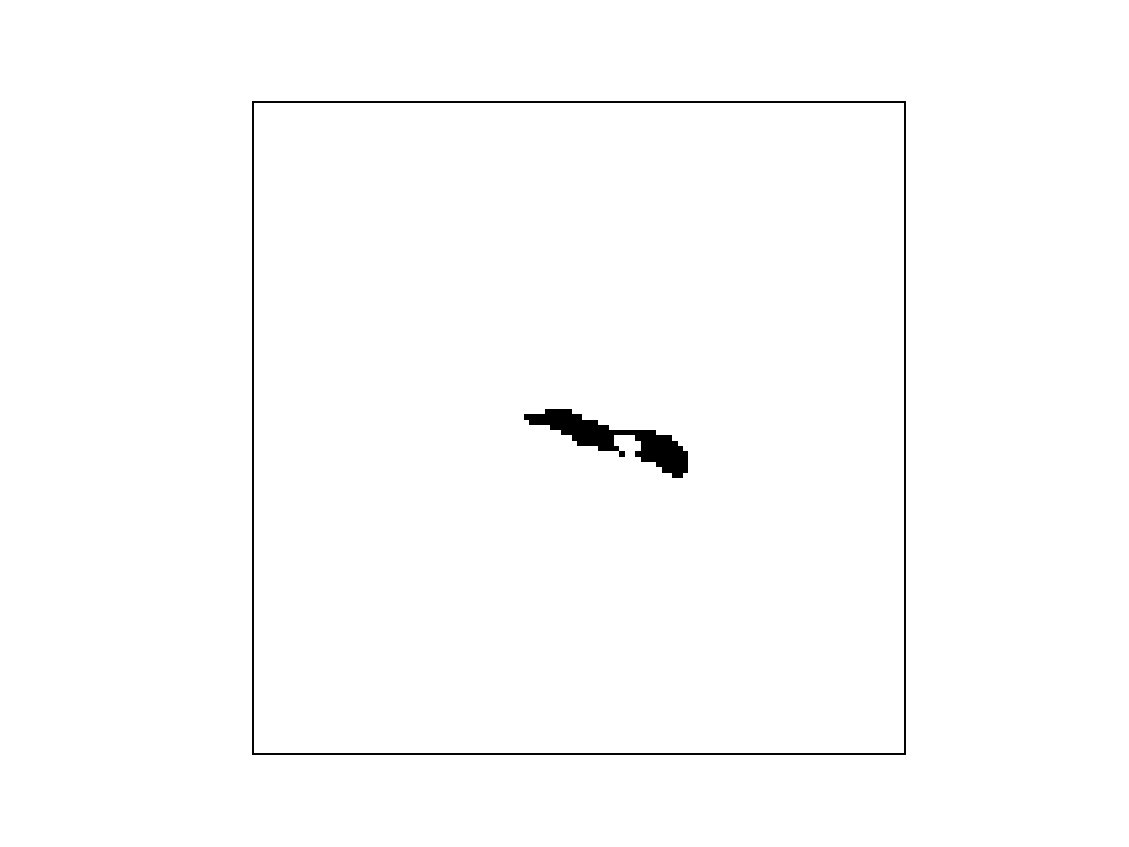

<IPython.core.display.Javascript object>


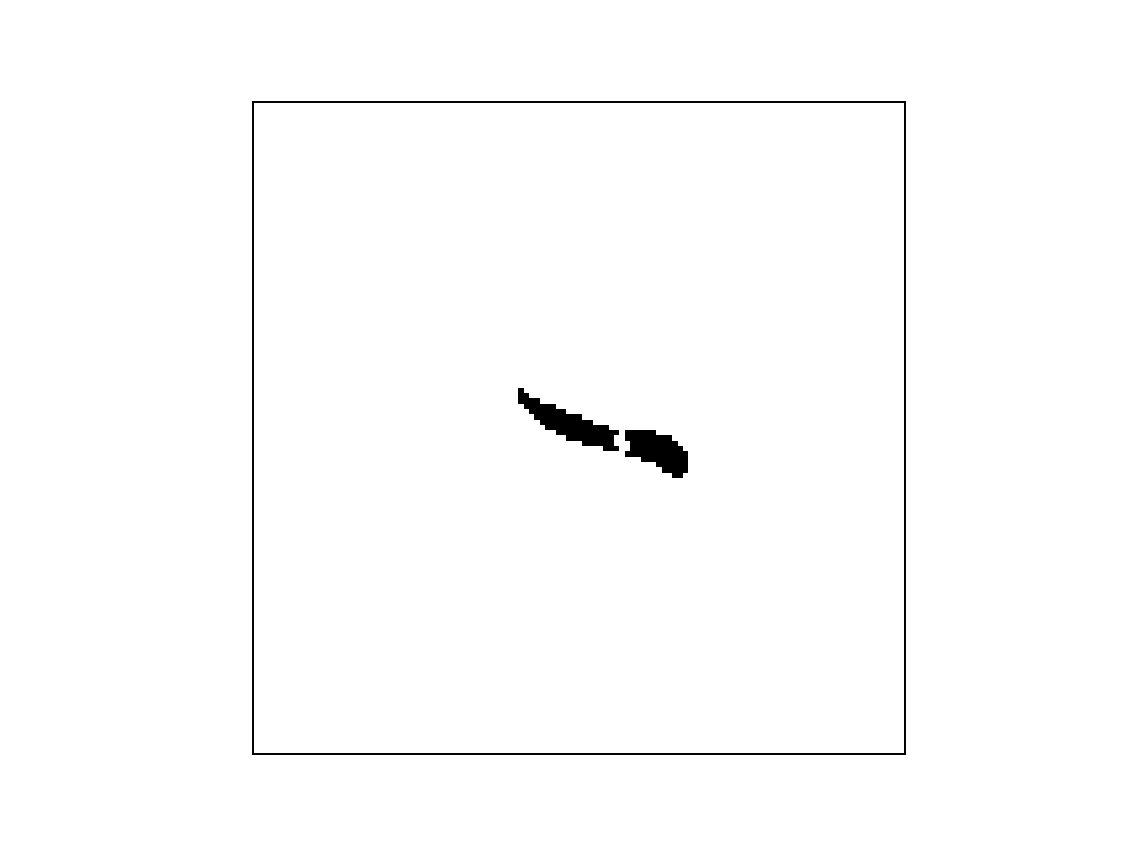

<IPython.core.display.Javascript object>


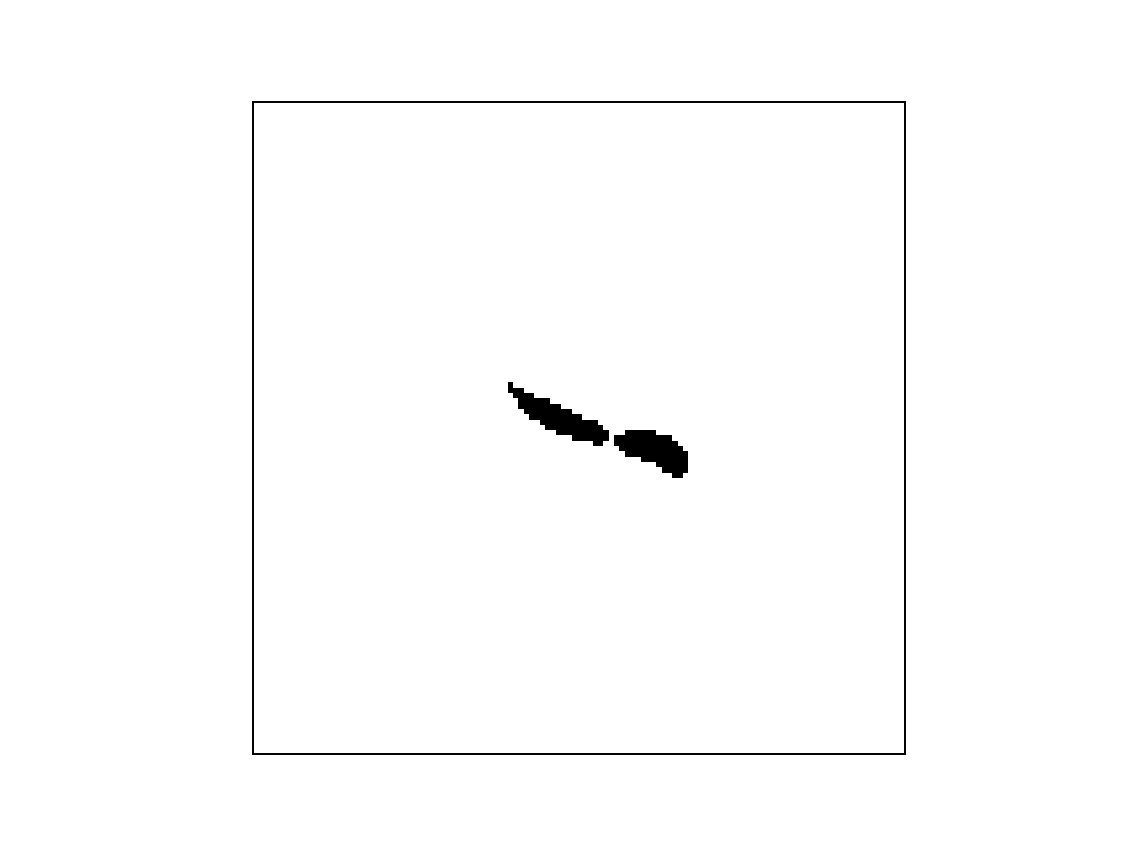

In [28]:
# CHANGE IF NECESSARY (E.G IF CHANGING THE ANALYZED FOLDER)
counter=1

os.chdir(home_path)
os.chdir(targetpath)

i_escape_box = counter + 1
# next stop: take background picture for future reference
iscrossing = False
while iscrossing != True:
    counter += 1
    
    #current_frame_animal_left = ndimage.filters.gaussian_filter(self.images[:,:,self.counter],
    #                                                            sigma=self.sigma_for_image_filtering)
    current_frame_animal_left = all_images[:,:,counter]
    #print(self.counter)

    # re-calculate the threshold for this particular image: - doesn't work well because changing the threshold
    # changes what is identified as the first animal and therefore makes it much harder to compare the current
    # image to the previous one.
    #leaving_box_thresh = thc.MeanThresh(current_frame_animal_left, self.signal, self.STD, self.first_roi)

    # depending on the signal (dark or bright) take the values less than the threshold, or greater, respectively
    # thresholded_escape_box_image = self.compare(current_frame_animal_left, leaving_box_thresh.thresh)
    thresholded_escape_box_image = compare(current_frame_animal_left, first_thresh.thresh)

    # Essentially subtract the current binary image from the first binary image
    subtracted_new_frame = np.bitwise_xor(thresholded_escape_box_image, first_image_thresholded)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(subtracted_new_frame[int(first_roi.row_min):int(first_roi.row_max),
                      int(first_roi.col_min):int(first_roi.col_max)], cmap='Greys')

    ax.tick_params(
                    axis='both',          # changes apply to the both axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    left=False,         # ticks along the left edge are off
                    labelbottom=False,
                    labelleft=False) 
    
    if save_plots: 
        fig.savefig('Fig1S3k_' + repr(counter) + '_waiting_for_leaving.eps')
    # extract the properties of object in the bounding box
    larval_properties = regionprops(label(CallImageROI(subtracted_new_frame, first_animal).small_image))

    # sort those object and find the largest one.
    boxed_animal = DescribeLargestObject(larval_properties, first_animal)

    # the if clause below just tests if the connected regions that were identified have similar properties
    # to the original larva.
    if boxed_animal.filled_area <= \
                    first_animal.filled_area + first_animal.filled_area * stringency_size \
        and boxed_animal.filled_area >= \
                    first_animal.filled_area - first_animal.filled_area * stringency_size \
        and boxed_animal.centroid_row <=\
                    first_animal.centroid_row + first_animal.centroid_row * stringency_centroid \
        and boxed_animal.centroid_row >= \
                    first_animal.centroid_row - first_animal.centroid_row * stringency_centroid \
        and boxed_animal.centroid_col <= \
                    first_animal.centroid_col + first_animal.centroid_col * stringency_centroid \
        and boxed_animal.centroid_col >= \
                    first_animal.centroid_col - first_animal.centroid_col * stringency_centroid:
        iscrossing = True
        # if the subtracted binary image is almost identical (controlled with the stringency* parameters)
        # the animal has left the original position.
        break
    else:
        i_escape_box +=1

next_frame = i_escape_box


In [29]:
# TODO: Test if it would be good to have a small pause here - this would give the animal time to really get out of the
#next_frame +=1

counter += 1

post_box_image = all_images[:, :, counter]


# Here we take the picture that has been taken after the larvae left the initial bbox and fill the original
# picture with the now empty bounding box to get a background without a larva

# Note! We make the picture 10% of the boxsize bigger than the found regionprops. Sometimes
# the thresholding does not catch faint parts of the larva so this is a safeguard against it!
# IT WILL BREAK IF THE BOXSIZE IS TOO BIG
goodbackground[first_animal.row_min - int(boxsize * 0.1):first_animal.row_max + int(boxsize * 0.1),
                    first_animal.col_min - int(boxsize * 0.1):first_animal.col_max + int(boxsize * 0.1)] = \
    post_box_image[first_animal.row_min - int(boxsize * 0.1):first_animal.row_max + int(boxsize * 0.1),
                    first_animal.col_min - int(boxsize * 0.1):first_animal.col_max + int(boxsize * 0.1)]

# also do this for the unfiltered background - just to get a nicer looking background image
unfiltered_background[first_animal.row_min - int(boxsize * 0.1):first_animal.row_max + int(boxsize * 0.1),
                    first_animal.col_min - int(boxsize * 0.1):first_animal.col_max + int(boxsize * 0.1)] = \
    post_box_image[first_animal.row_min - int(boxsize * 0.1):first_animal.row_max + int(boxsize * 0.1),
                    first_animal.col_min - int(boxsize * 0.1):first_animal.col_max + int(boxsize * 0.1)]

smoothed_goodbackground = ndimage.filters.gaussian_filter(goodbackground, sigma=1)

# Note, the jpg is not used in Fig1S3, only save the eps below
# imageio.imsave('Fig1S3N_Background.jpg', unfiltered_background)
# print('Background reconstruction completed and image saved')

<IPython.core.display.Javascript object>


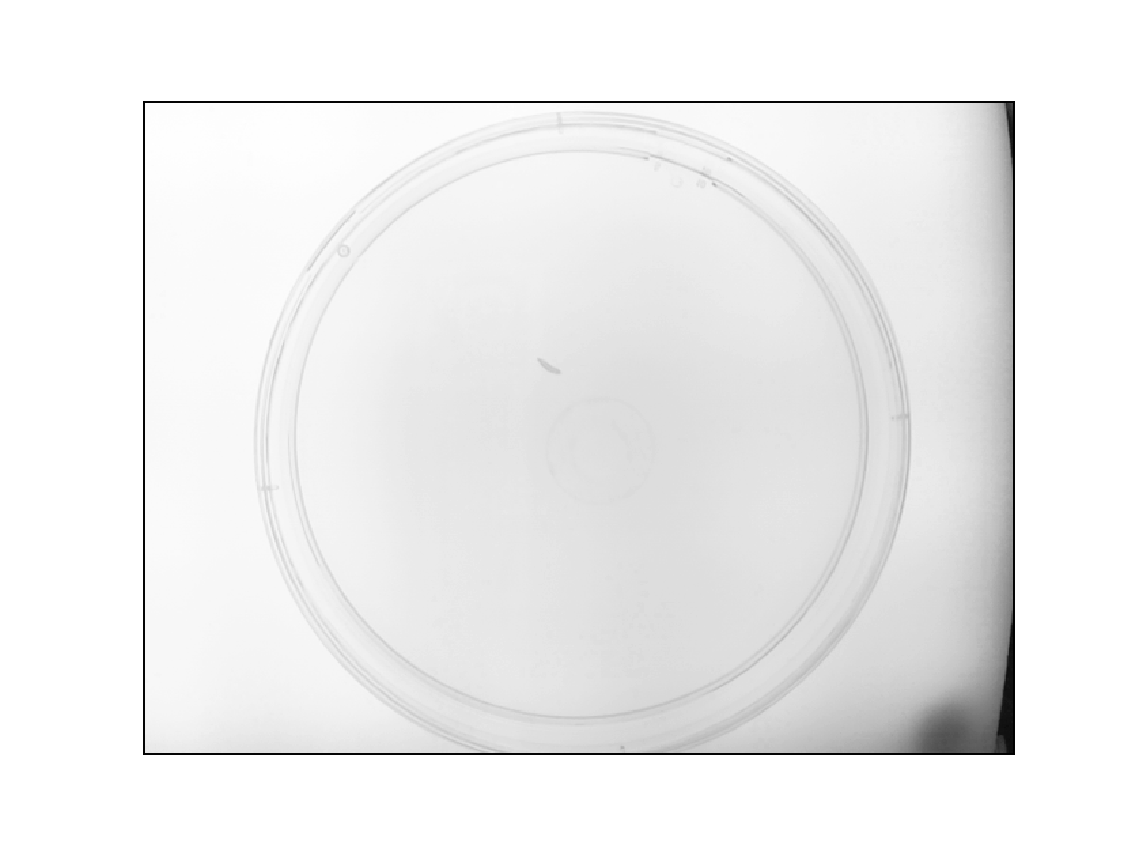

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(post_box_image, cmap = 'Greys_r')
ax.tick_params(
                axis='both',          # changes apply to the both axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                left=False,         # ticks along the left edge are off
                labelbottom=False,
                labelleft=False) 
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3LM_ImageAfterLeft.eps')

<IPython.core.display.Javascript object>


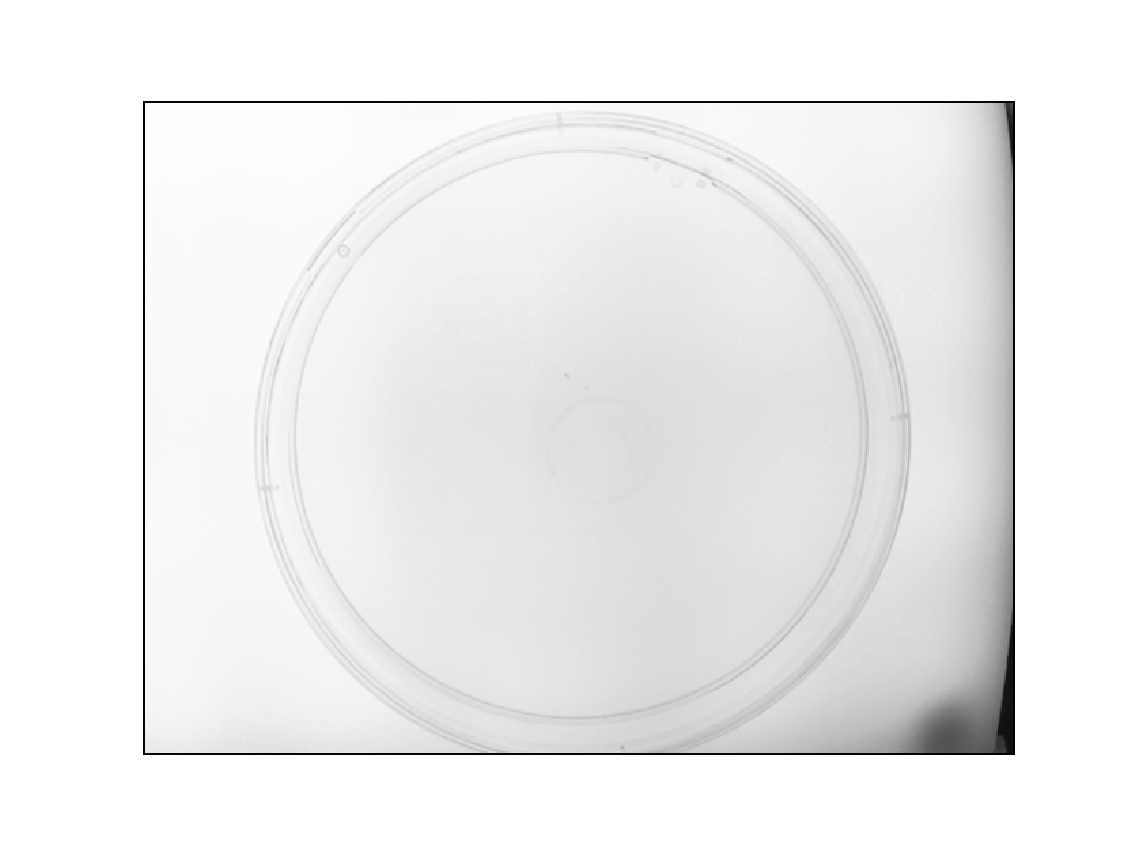

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(unfiltered_background, cmap = 'Greys_r')
ax.tick_params(
                axis='both',          # changes apply to the both axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                left=False,         # ticks along the left edge are off
                labelbottom=False,
                labelleft=False)
os.chdir(home_path)
os.chdir(targetpath)

if save_plots: 
    fig.savefig('Fig1S3N_ReconstructedImage.eps')